# HDBSCAN Clustering for Pleiades Membership Identification



## Import Library

In [128]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import hdbscan
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

## Load Data

In [129]:
df = pd.read_csv('pleiadesdataset.csv')
print(f"Baris awal: {len(df)}")

Baris awal: 176673


## Cleaning & Feature Engineering

In [130]:
cols = ['ra','dec','parallax','pmra','pmdec',
        'phot_bp_mean_mag','phot_rp_mean_mag','phot_g_mean_mag','ruwe']
data = df[cols].copy()

# filter parallax positif
data = data[data["parallax"] > 0].copy()

# warna dan magnitudo absolut
data['color'] = data['phot_bp_mean_mag'] - data['phot_rp_mean_mag']
data['M_G']   = data['phot_g_mean_mag'] + 5 * np.log10(data['parallax']/1000) + 5

# filter kualitas RUWE dan drop missing
data = data[data['ruwe'] < 1.4].dropna(subset=['parallax','pmra','pmdec','color','M_G'])
print(f"Baris setelah cleaning: {len(data)}")

Baris setelah cleaning: 124436


## Standardize Features

In [131]:
features = ['parallax','pmra','pmdec','color','M_G']
scaler   = StandardScaler()
X        = scaler.fit_transform(data[features])

## HDBSCAN clustering

In [132]:
clusterer     = hdbscan.HDBSCAN(min_cluster_size=30, gen_min_span_tree=True)
labels        = clusterer.fit_predict(X)
data['cluster']     = labels
data['probability'] = clusterer.probabilities_

c:\Users\BINORION\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\BINORION\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [133]:
unique_labels = sorted(data['cluster'].unique())
print("\nStatistik deskriptif per cluster:")
print(data.groupby('cluster')[features].agg(['count','mean','std','median']))


Statistik deskriptif per cluster:
        parallax                                  pmra                        \
           count      mean       std    median   count       mean        std   
cluster                                                                        
-1          1250  6.210686  5.026705  5.347504    1250  31.107833  59.613100   
 0          1151  7.290934  0.499311  7.349364    1151  19.686054   2.244598   
 1        122035  0.905670  0.837525  0.655263  122035   2.666412   6.211842   

                     pmdec                                    color            \
            median   count       mean        std     median   count      mean   
cluster                                                                         
-1       29.035957    1250 -40.317112  57.166540 -35.329257    1250  2.061844   
 0       19.806101    1151 -44.924833   3.085357 -45.338442    1151  2.551569   
 1        1.396745  122035  -4.280871   6.247992  -2.620542  122035  1.540796  

In [134]:
# Menghitung cluster tanpa noise
n_clusters    = len([lbl for lbl in unique_labels if lbl != -1])
print(f"Terdeteksi {n_clusters} cluster (noise = -1)")

Terdeteksi 2 cluster (noise = -1)


In [ ]:
data_clustered = data.copy()

## Visualisasi gabungan distribusi fitur

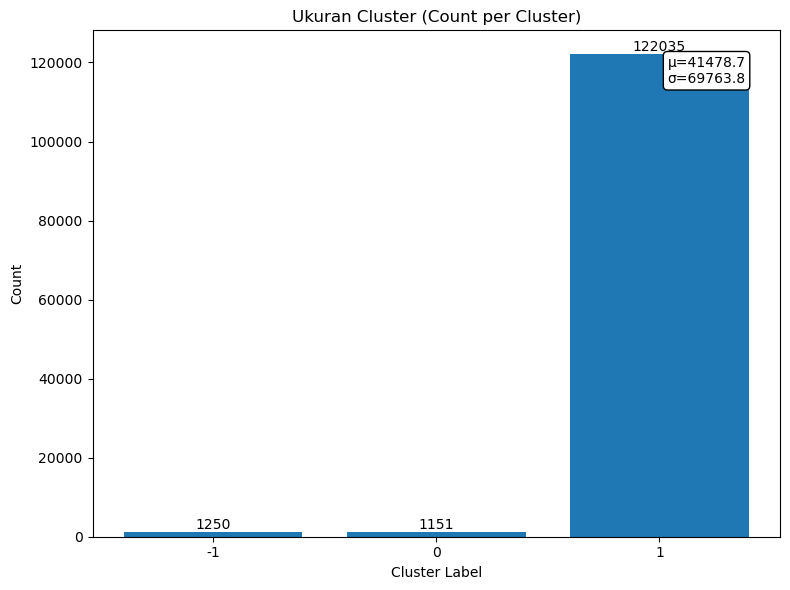

In [136]:
counts = data['cluster'].value_counts().sort_index()
plt.figure(figsize=(8,6))
bars = plt.bar(counts.index.astype(str), counts.values)
plt.title('Ukuran Cluster (Count per Cluster)')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f"{int(h)}", ha='center', va='bottom')
mean_size, std_size = counts.mean(), counts.std()
plt.text(0.95, 0.95, f"μ={mean_size:.1f}\nσ={std_size:.1f}",
         transform=plt.gca().transAxes, ha='right', va='top',
         bbox=dict(boxstyle="round", fc="w"))
plt.tight_layout()
plt.show()

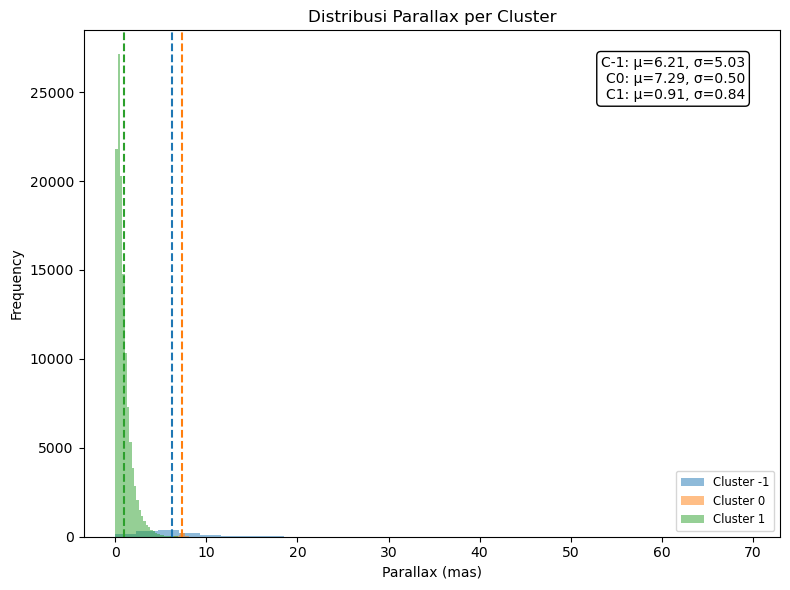

In [ ]:
# Histogram Parallax 
plt.figure(figsize=(8,6))
for lbl in unique_labels:
    subset = data[data['cluster']==lbl]
    plt.hist(subset['parallax'], bins=30, alpha=0.5, label=f'Cluster {lbl}')
par_means = data.groupby('cluster')['parallax'].mean()
par_stds  = data.groupby('cluster')['parallax'].std()
colors = plt.cm.tab10.colors
for i, lbl in enumerate(unique_labels):
    plt.axvline(par_means[lbl], color=colors[i%10], linestyle='--')
plt.title('Distribusi Parallax per Cluster')
plt.xlabel('Parallax (mas)')
plt.ylabel('Frequency')
plt.legend(fontsize='small')
text = "\n".join([f"C{lbl}: μ={par_means[lbl]:.2f}, σ={par_stds[lbl]:.2f}" for lbl in unique_labels])
plt.text(0.95, 0.95, text, transform=plt.gca().transAxes,
         ha='right', va='top', bbox=dict(boxstyle="round", fc="w"))
plt.tight_layout()
plt.show()

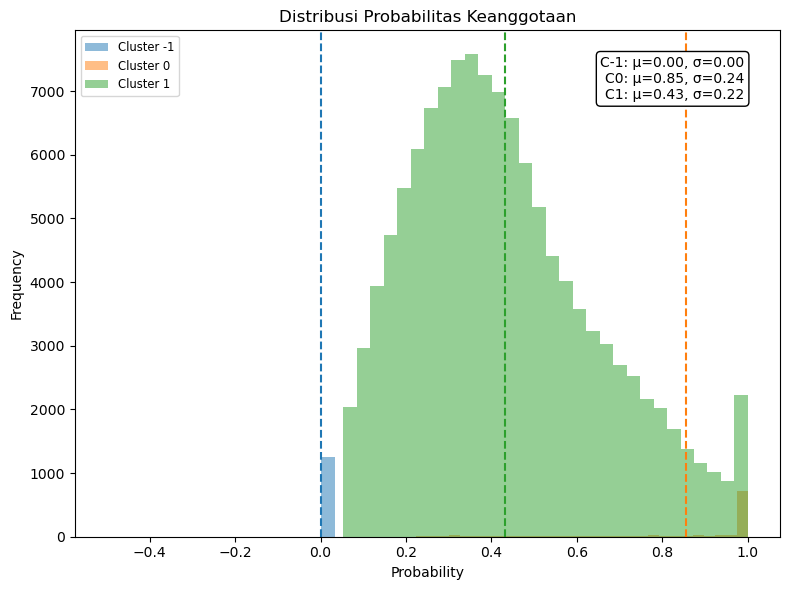

In [138]:
plt.figure(figsize=(8,6))
for lbl in unique_labels:
    subset = data[data['cluster']==lbl]
    plt.hist(subset['probability'], bins=30, alpha=0.5, label=f'Cluster {lbl}')
prob_means = data.groupby('cluster')['probability'].mean()
prob_stds  = data.groupby('cluster')['probability'].std()
for i, lbl in enumerate(unique_labels):
    plt.axvline(prob_means[lbl], color=colors[i%10], linestyle='--')
plt.title('Distribusi Probabilitas Keanggotaan')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend(fontsize='small')
text = "\n".join([f"C{lbl}: μ={prob_means[lbl]:.2f}, σ={prob_stds[lbl]:.2f}" for lbl in unique_labels])
plt.text(0.95, 0.95, text, transform=plt.gca().transAxes,
         ha='right', va='top', bbox=dict(boxstyle="round", fc="w"))
plt.tight_layout()
plt.show()

C:\Users\BINORION\AppData\Local\Temp\ipykernel_18884\947093076.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pm_means = data.groupby('cluster').apply(lambda df: np.sqrt((df['pmra']**2+df['pmdec']**2)).mean())
C:\Users\BINORION\AppData\Local\Temp\ipykernel_18884\947093076.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pm_stds  = data.groupby('cluster').apply(lambda df: np.sqrt((df['pmra']**2+df['p

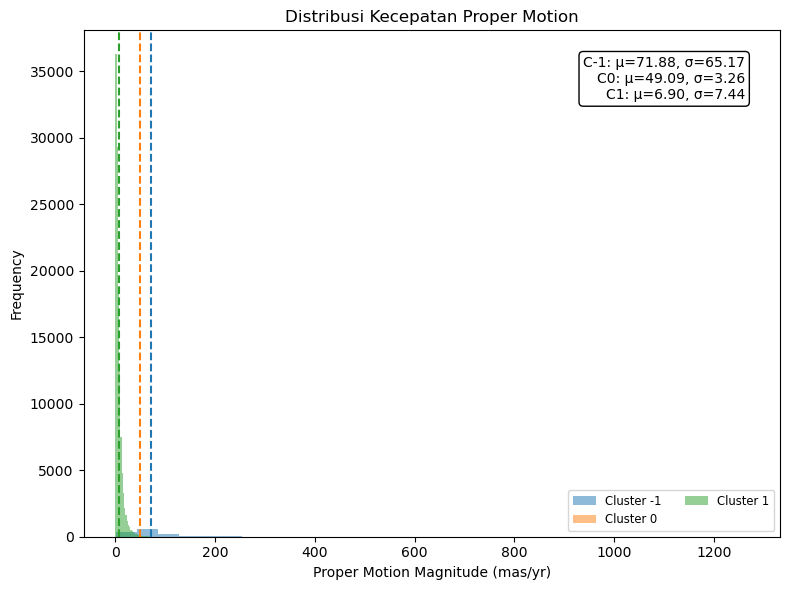

In [ ]:
# 10. Histogram Proper Motion Magnitude
plt.figure(figsize=(8,6))
for lbl in unique_labels:
    subset = data[data['cluster']==lbl]
    pm_mag = np.sqrt(subset['pmra']**2 + subset['pmdec']**2)
    plt.hist(pm_mag, bins=30, alpha=0.5, label=f'Cluster {lbl}')
pm_means = data.groupby('cluster').apply(lambda df: np.sqrt((df['pmra']**2+df['pmdec']**2)).mean())
pm_stds  = data.groupby('cluster').apply(lambda df: np.sqrt((df['pmra']**2+df['pmdec']**2)).std())
for i, lbl in enumerate(unique_labels):
    plt.axvline(pm_means[lbl], color=colors[i%10], linestyle='--')
plt.title('Distribusi Kecepatan Proper Motion')
plt.xlabel('Proper Motion Magnitude (mas/yr)')
plt.ylabel('Frequency')
plt.legend(fontsize='small', ncol=2)
text = "\n".join([f"C{lbl}: μ={pm_means[lbl]:.2f}, σ={pm_stds[lbl]:.2f}" for lbl in unique_labels])
plt.text(0.95, 0.95, text, transform=plt.gca().transAxes,
         ha='right', va='top', bbox=dict(boxstyle="round", fc="w"))
plt.tight_layout()
plt.show()

## Visualisasi gabungan sky + quiver (posisi & proper motion)

In [140]:
from matplotlib import cm
cmap = cm.get_cmap('tab10', len(unique_labels))
cluster_colors = {lbl: cmap(i) for i, lbl in enumerate(unique_labels)}
MAX_ARROWS = 500

C:\Users\BINORION\AppData\Local\Temp\ipykernel_18884\4064032492.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_labels))


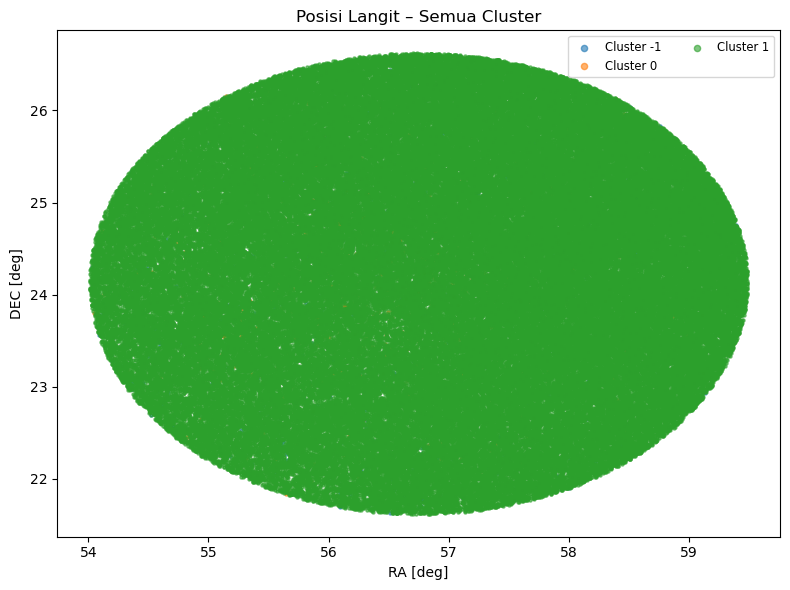

In [143]:
plt.figure(figsize=(8,6))
for lbl in unique_labels:
    subset = data[data['cluster']==lbl]
    plt.scatter(subset['ra'], subset['dec'], s=5, alpha=0.6, label=f'Cluster {lbl}')
plt.xlabel('RA [deg]'); plt.ylabel('DEC [deg]')
plt.title('Posisi Langit – Semua Cluster')
plt.legend(markerscale=2, fontsize='small', ncol=2)
plt.tight_layout(); plt.show()

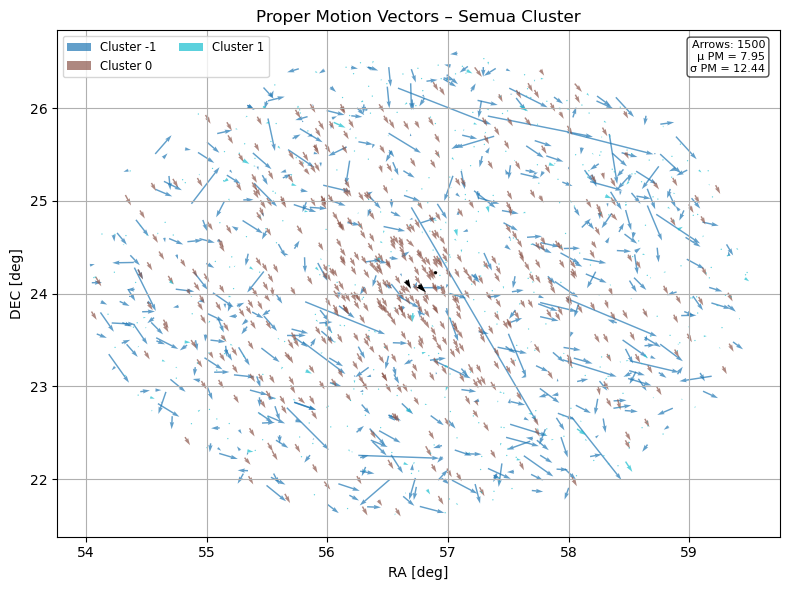

In [144]:
plt.figure(figsize=(8,6))
for lbl in unique_labels:
    subset = data[data['cluster']==lbl]
    arrows = subset.sample(min(len(subset), MAX_ARROWS), random_state=0)
    plt.quiver(arrows['ra'], arrows['dec'], arrows['pmra'], arrows['pmdec'],
               angles='xy', scale_units='xy', scale=500, width=0.002,
               alpha=0.7, color=cluster_colors[lbl], label=f'Cluster {lbl}')
centroids = data.groupby('cluster')[['ra','dec','pmra','pmdec']].mean()
for lbl in unique_labels:
    c = centroids.loc[lbl]
    plt.quiver(c['ra'], c['dec'], c['pmra'], c['pmdec'],
               angles='xy', scale_units='xy', scale=500, width=0.005, color='black')
pm_mag_all = np.sqrt(data['pmra']**2 + data['pmdec']**2)
summary = (f"Arrows: {sum(min(len(data[data['cluster']==lbl]), MAX_ARROWS) for lbl in unique_labels)}\n"
           f"μ PM = {pm_mag_all.mean():.2f}\nσ PM = {pm_mag_all.std():.2f}")
plt.text(0.98, 0.98, summary, transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=8,
         bbox=dict(boxstyle="round,pad=0.3", fc="w", alpha=0.7))
plt.xlabel('RA [deg]'); plt.ylabel('DEC [deg]')
plt.title('Proper Motion Vectors – Semua Cluster')
plt.legend(fontsize='small', ncol=2)
plt.grid(True); plt.tight_layout(); plt.show()

## 7. Visualisasi per cluster: sky, quiver, & distribusi fitur (2×3 grid)


===== Cluster -1: 1250 bintang =====


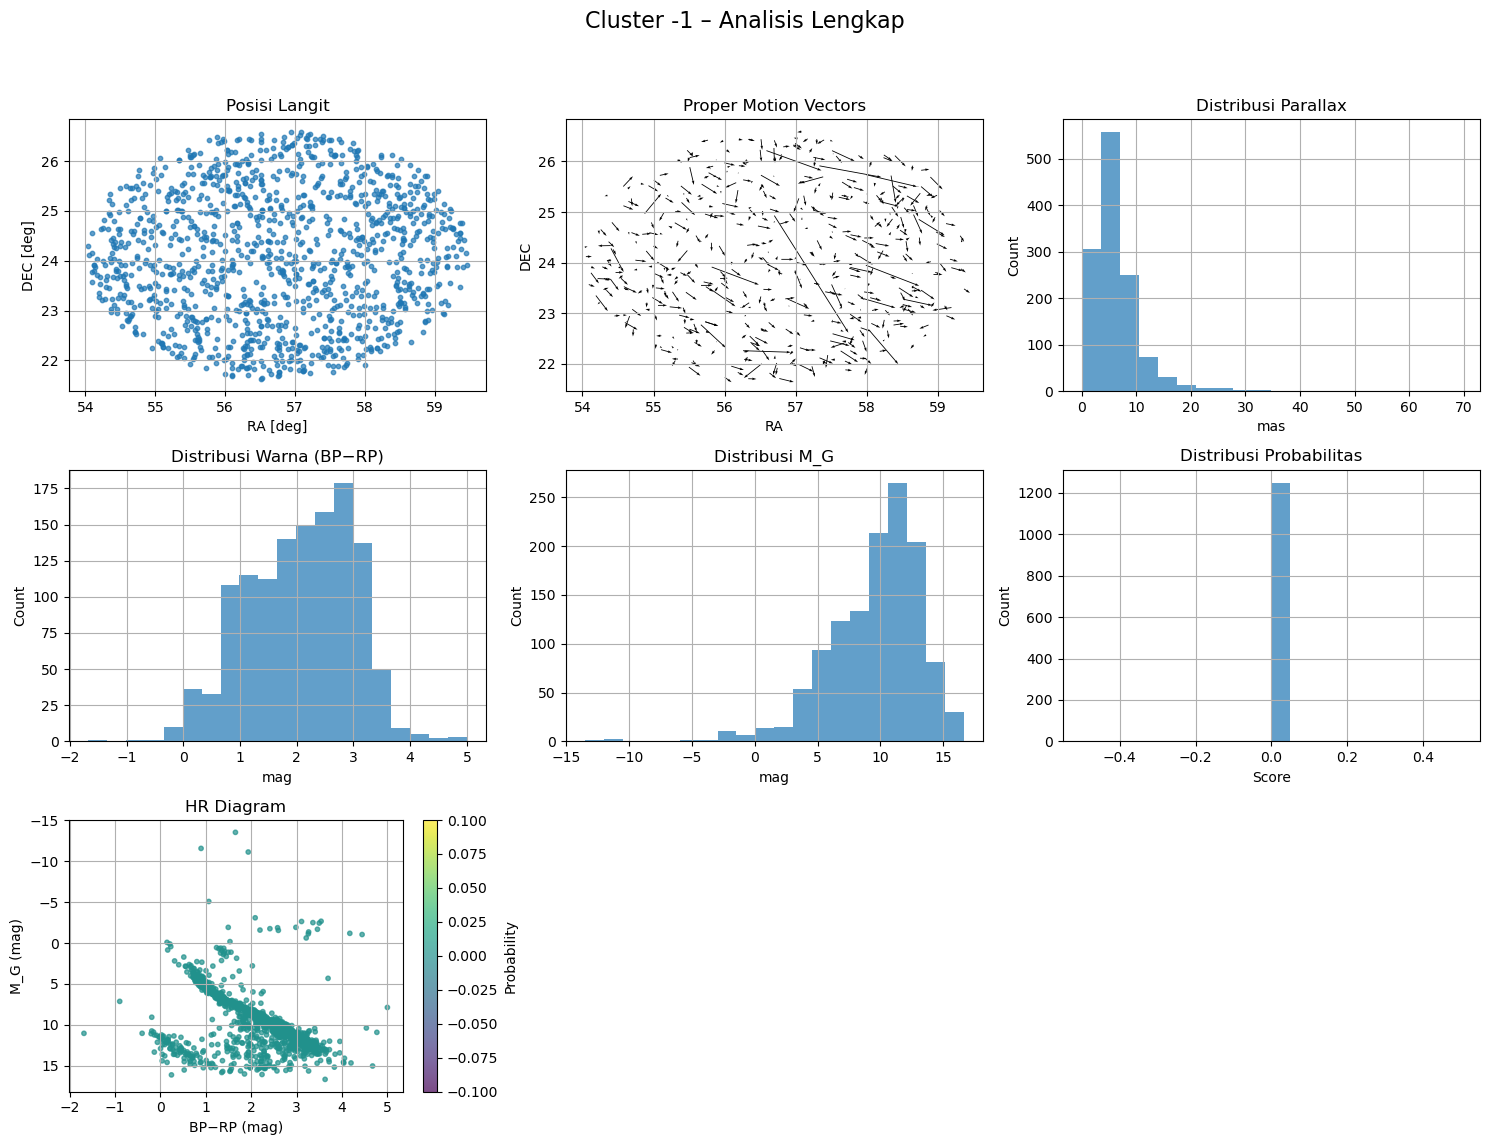


===== Cluster 0: 1151 bintang =====


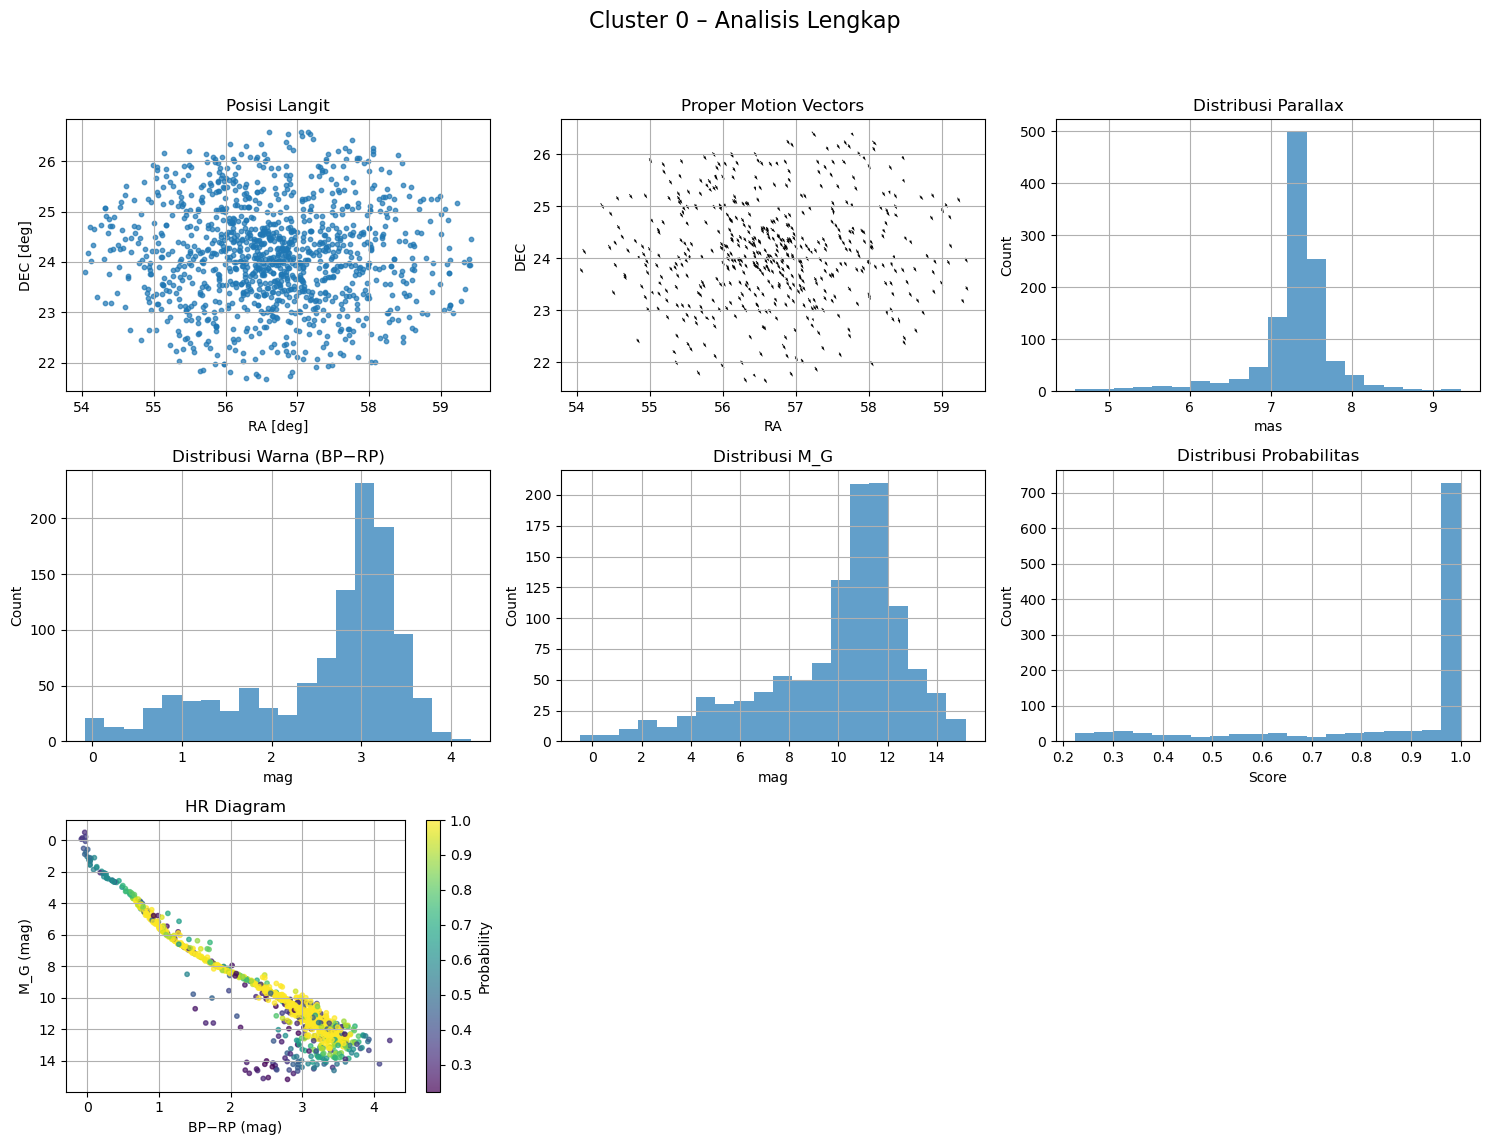


===== Cluster 1: 122035 bintang =====


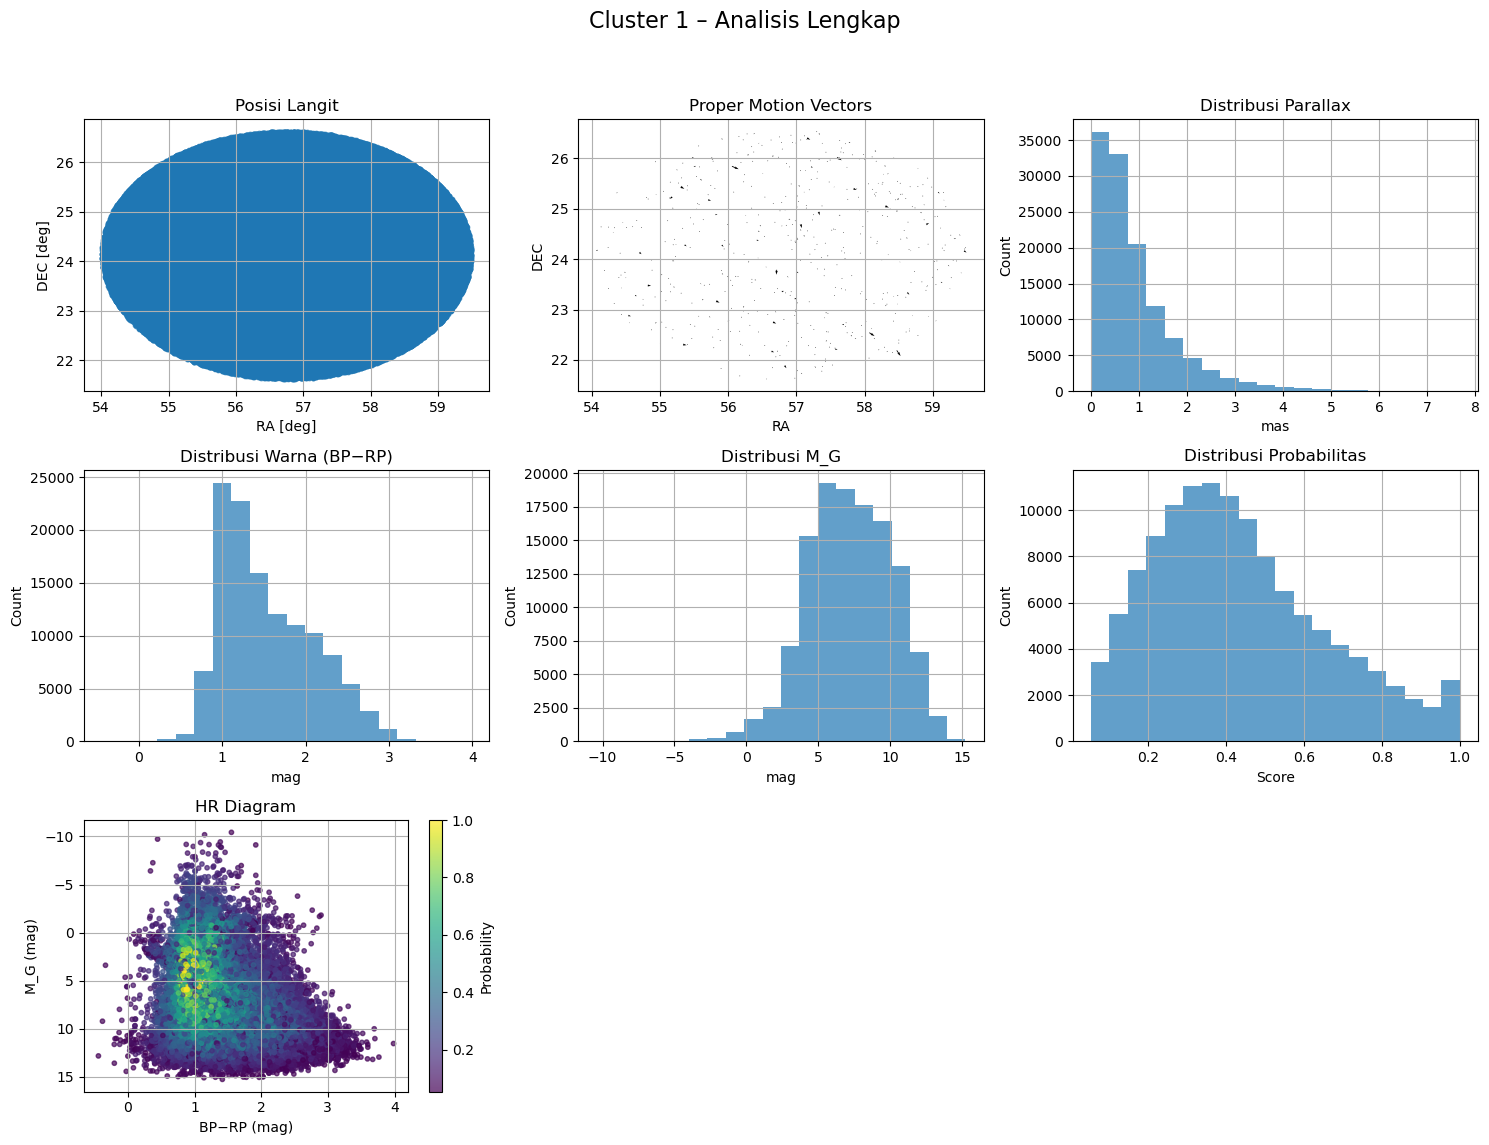

In [ ]:
for lbl in unique_labels:
    subset = data[data['cluster']==lbl]
    count  = len(subset)
    print(f"\n===== Cluster {lbl}: {count} bintang =====")

    fig, axes = plt.subplots(3, 3, figsize=(15,12))
    fig.suptitle(f'Cluster {lbl} – Analisis Lengkap', fontsize=16)
    # posisi langit
    ax = axes[0,0]
    ax.scatter(subset['ra'], subset['dec'], s=10, alpha=0.7)
    ax.set_title('Posisi Langit'); ax.set_xlabel('RA [deg]'); ax.set_ylabel('DEC [deg]'); ax.grid(True)
    # proper motion vectors
    ax = axes[0,1]
    arrows = subset.sample(min(count, MAX_ARROWS), random_state=0)
    ax.quiver(arrows['ra'], arrows['dec'], arrows['pmra'], arrows['pmdec'],
              angles='xy', scale_units='xy', scale=500, width=0.002)
    ax.set_title('Proper Motion Vectors'); ax.set_xlabel('RA'); ax.set_ylabel('DEC'); ax.grid(True)
    # histogram parallax
    ax = axes[0,2]
    ax.hist(subset['parallax'], bins=20, alpha=0.7)
    ax.set_title('Distribusi Parallax'); ax.set_xlabel('mas'); ax.set_ylabel('Count'); ax.grid(True)
    # histogram warna
    ax = axes[1,0]
    ax.hist(subset['color'], bins=20, alpha=0.7)
    ax.set_title('Distribusi Warna (BP−RP)'); ax.set_xlabel('mag'); ax.set_ylabel('Count'); ax.grid(True)
    # histogram M_G
    ax = axes[1,1]
    ax.hist(subset['M_G'], bins=20, alpha=0.7)
    ax.set_title('Distribusi M_G'); ax.set_xlabel('mag'); ax.set_ylabel('Count'); ax.grid(True)
    # histogram probability
    ax = axes[1,2]
    ax.hist(subset['probability'], bins=20, alpha=0.7)
    ax.set_title('Distribusi Probabilitas'); ax.set_xlabel('Score'); ax.set_ylabel('Count'); ax.grid(True)
    # HR diagram
    ax = axes[2,0]
    sc = ax.scatter(subset['color'], subset['M_G'], s=10, alpha=0.7, c=subset['probability'], cmap='viridis')
    ax.invert_yaxis()
    ax.set_title('HR Diagram'); ax.set_xlabel('BP−RP (mag)'); ax.set_ylabel('M_G (mag)'); ax.grid(True)
    plt.colorbar(sc, ax=ax, label='Probability')
    # Empty
    axes[2,1].axis('off'); axes[2,2].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


===== Cluster -1 – Statistik Deskriptif =====
        parallax       pmra      pmdec     color        M_G
mean    6.210686  31.107833 -40.317112  2.061844   9.621173
std     5.026705  59.613100  57.166540  0.928987   3.622030
median  5.347504  29.035957 -35.329257  2.170675  10.347444


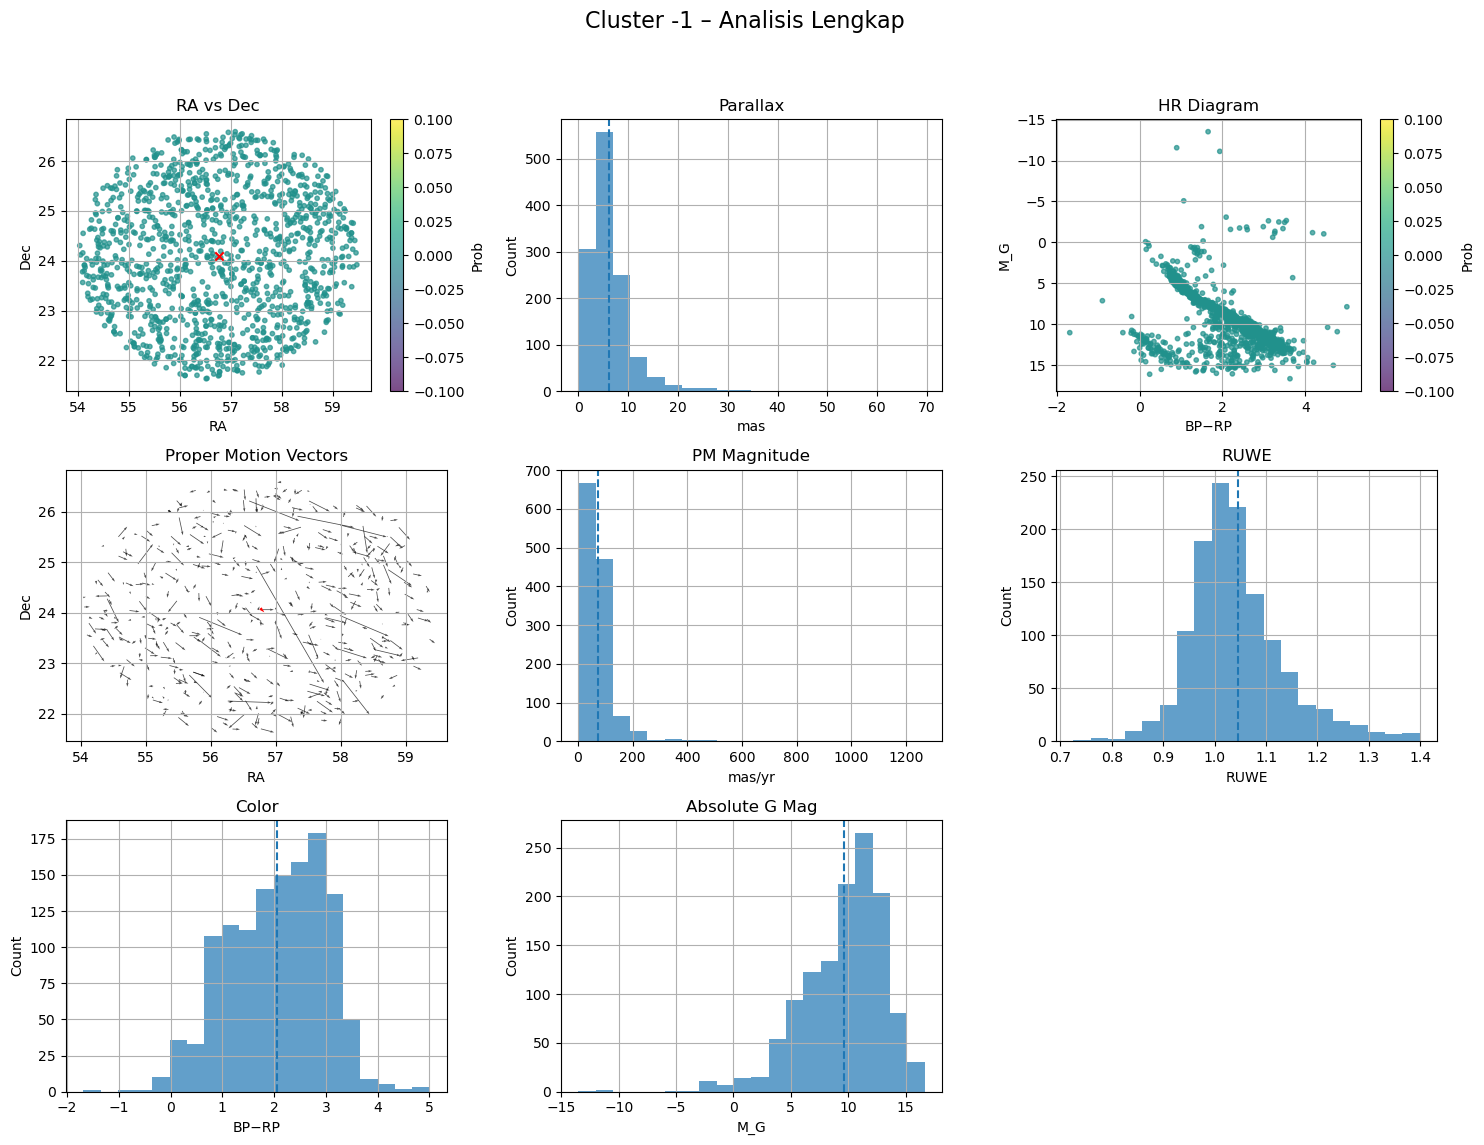


===== Cluster 0 – Statistik Deskriptif =====
        parallax       pmra      pmdec     color        M_G
mean    7.290934  19.686054 -44.924833  2.551569   9.908585
std     0.499311   2.244598   3.085357  0.926061   2.956889
median  7.349364  19.806101 -45.338442  2.924084  10.784653


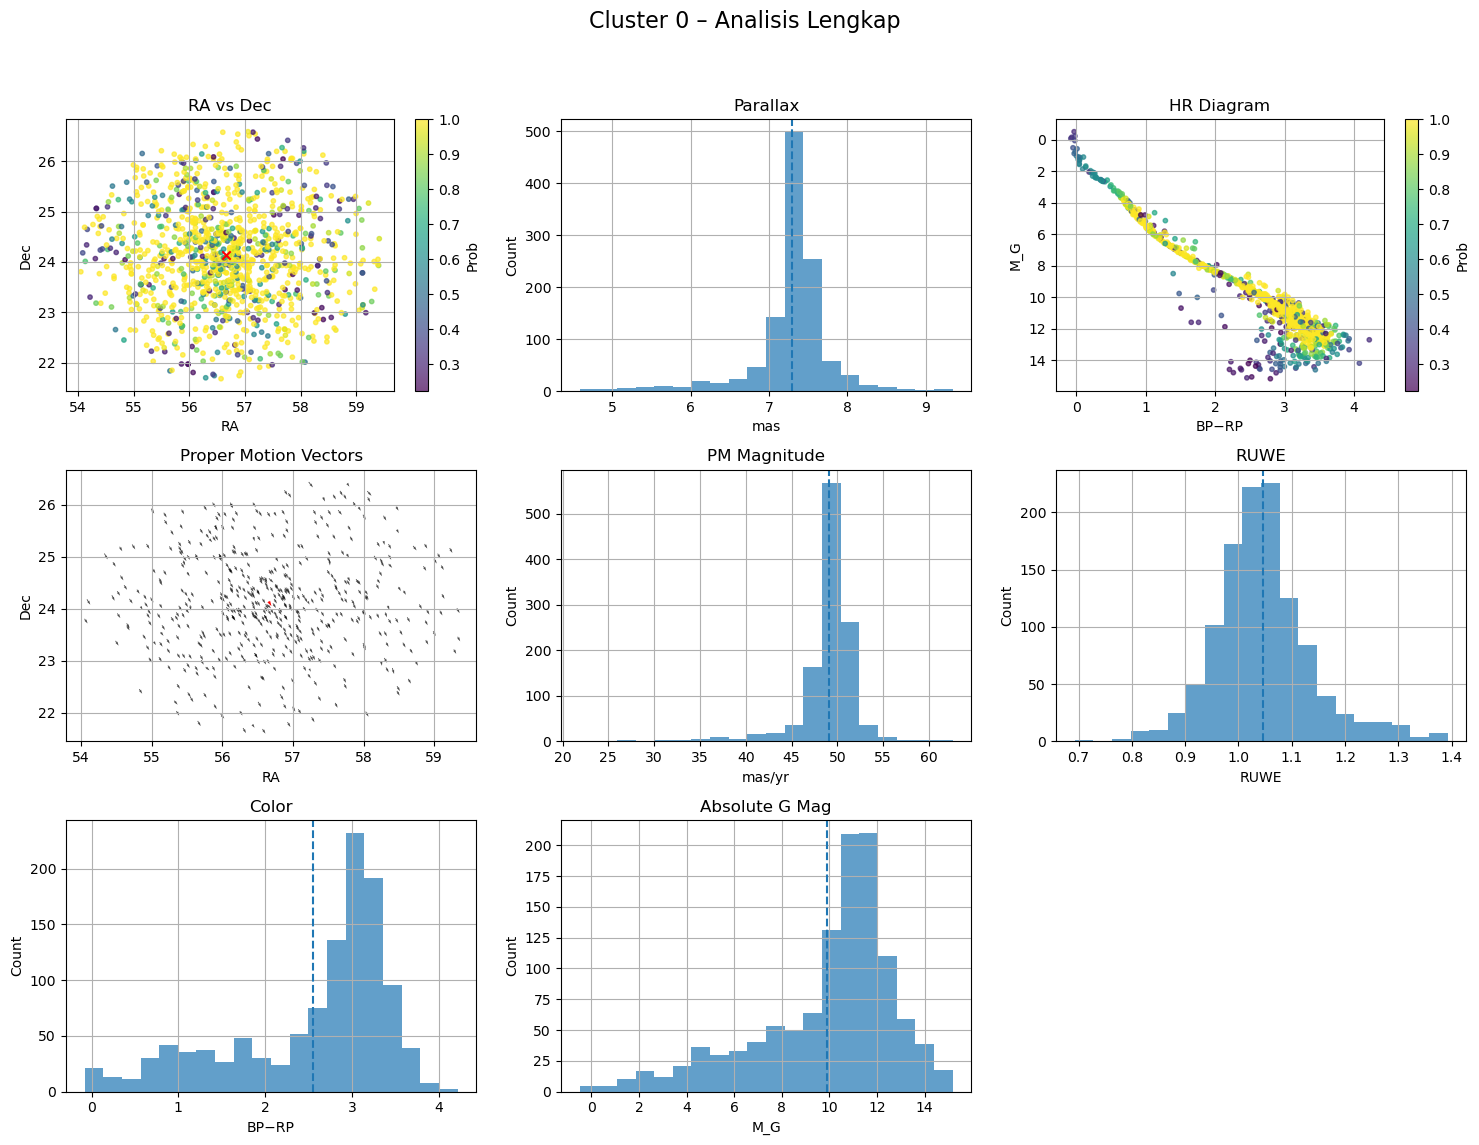


===== Cluster 1 – Statistik Deskriptif =====
        parallax      pmra     pmdec     color       M_G
mean    0.905670  2.666412 -4.280871  1.540796  7.211825
std     0.837525  6.211842  6.247992  0.551680  2.927729
median  0.655263  1.396745 -2.620542  1.402704  7.200315


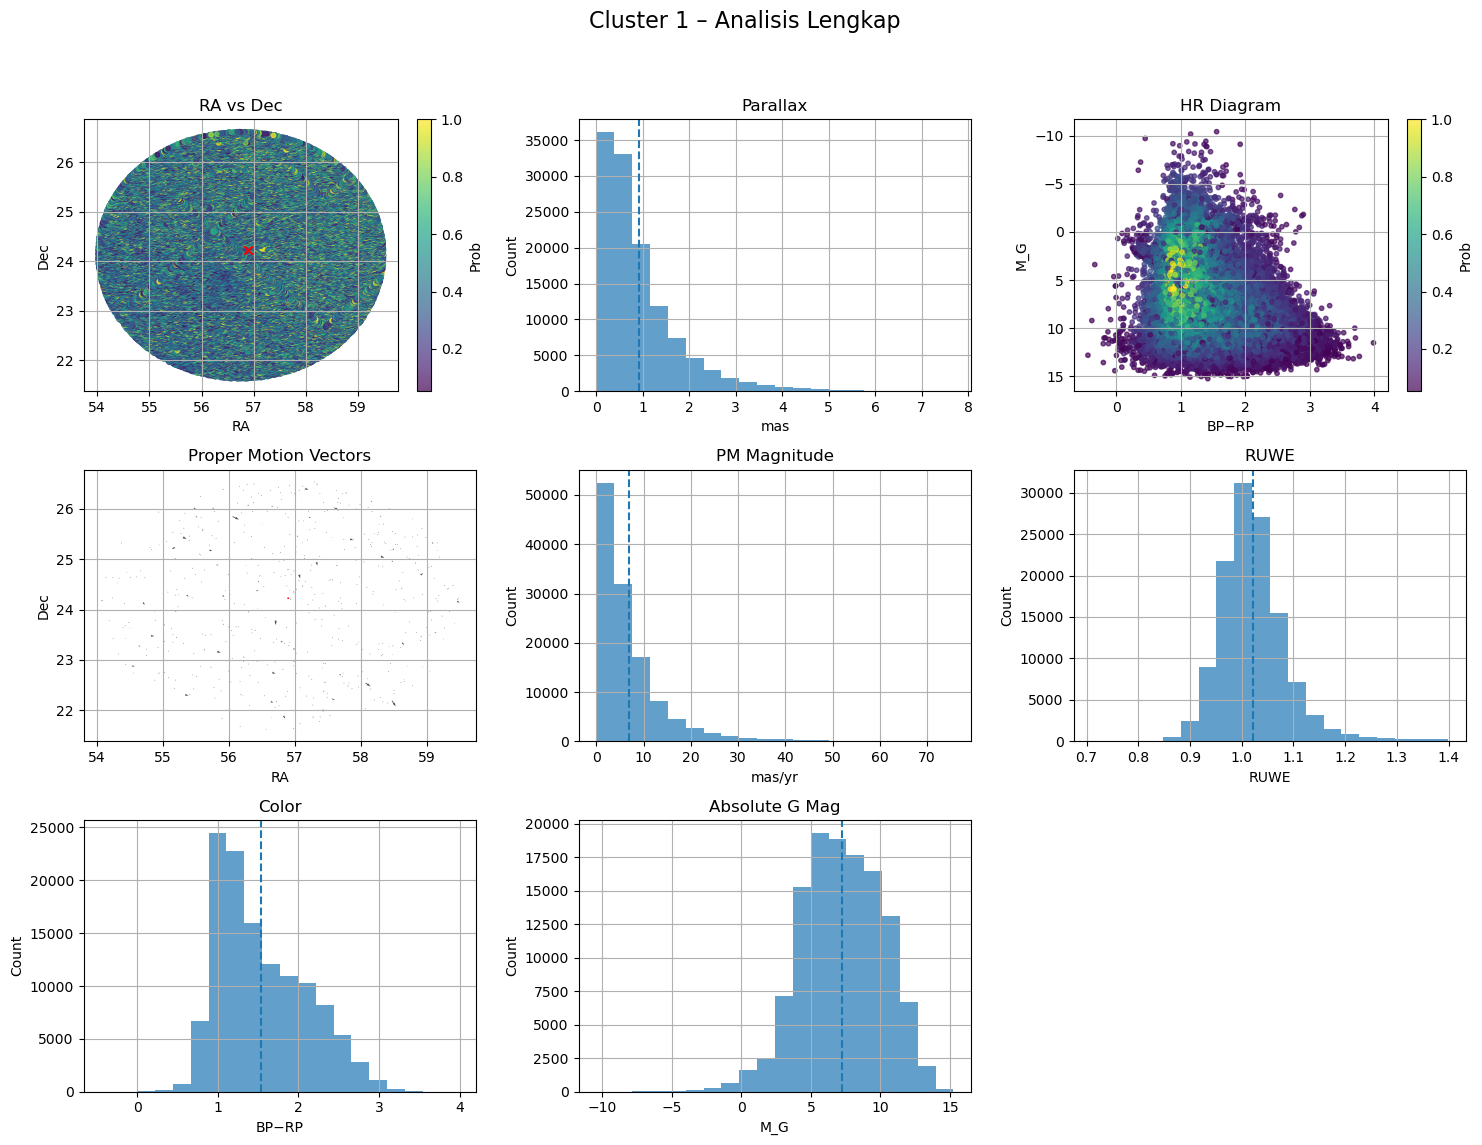

In [146]:
for lbl in unique_labels:
    subset = data[data['cluster']==lbl]
    ra_c, dec_c     = subset['ra'].mean(), subset['dec'].mean()
    pmra_c, pmdec_c = subset['pmra'].mean(), subset['pmdec'].mean()

    # ringkasan deskriptif
    desc = subset[features].describe().loc[['mean','std','50%']].rename(index={'50%':'median'})
    print(f"\n===== Cluster {lbl} – Statistik Deskriptif =====")
    print(desc)

    fig, axes = plt.subplots(3,3,figsize=(15,12))
    fig.suptitle(f'Cluster {lbl} – Analisis Lengkap', fontsize=16)
    # RA vs Dec
    ax = axes[0,0]; sc = ax.scatter(subset['ra'], subset['dec'], s=10, alpha=0.7, c=subset['probability'], cmap='viridis')
    ax.scatter(ra_c, dec_c, color='red', marker='x'); ax.set(title='RA vs Dec', xlabel='RA', ylabel='Dec'); ax.grid(True); plt.colorbar(sc, ax=ax, label='Prob')
    # Parallax
    ax = axes[0,1]; ax.hist(subset['parallax'], bins=20, alpha=0.7)
    ax.axvline(subset['parallax'].mean(), linestyle='--'); ax.set(title='Parallax', xlabel='mas', ylabel='Count'); ax.grid(True)
    # HR Diagram
    ax = axes[0,2]; sc = ax.scatter(subset['color'], subset['M_G'], s=10, alpha=0.7, c=subset['probability'], cmap='viridis')
    ax.invert_yaxis(); ax.set(title='HR Diagram', xlabel='BP−RP', ylabel='M_G'); ax.grid(True); plt.colorbar(sc, ax=ax, label='Prob')
    # Proper Motion Vectors
    ax = axes[1,0]; arrows = subset.sample(min(len(subset), MAX_ARROWS), random_state=0)
    ax.quiver(arrows['ra'], arrows['dec'], arrows['pmra'], arrows['pmdec'], angles='xy', scale_units='xy', scale=500, width=0.002, alpha=0.7)
    ax.quiver(ra_c, dec_c, pmra_c, pmdec_c, angles='xy', scale_units='xy', scale=500, width=0.005, color='red')
    ax.set(title='Proper Motion Vectors', xlabel='RA', ylabel='Dec'); ax.grid(True)
    # PM Magnitude
    ax = axes[1,1]; pm_vals = np.sqrt(subset['pmra']**2 + subset['pmdec']**2)
    ax.hist(pm_vals, bins=20, alpha=0.7); ax.axvline(pm_vals.mean(), linestyle='--')
    ax.set(title='PM Magnitude', xlabel='mas/yr', ylabel='Count'); ax.grid(True)
    # RUWE
    ax = axes[1,2]; ax.hist(subset['ruwe'], bins=20, alpha=0.7); ax.axvline(subset['ruwe'].mean(), linestyle='--')
    ax.set(title='RUWE', xlabel='RUWE', ylabel='Count'); ax.grid(True)
    # Color
    ax = axes[2,0]; ax.hist(subset['color'], bins=20, alpha=0.7); ax.axvline(subset['color'].mean(), linestyle='--')
    ax.set(title='Color', xlabel='BP−RP', ylabel='Count'); ax.grid(True)
    # M_G
    ax = axes[2,1]; ax.hist(subset['M_G'], bins=20, alpha=0.7); ax.axvline(subset['M_G'].mean(), linestyle='--')
    ax.set(title='Absolute G Mag', xlabel='M_G', ylabel='Count'); ax.grid(True)
    axes[2,2].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

C:\Users\BINORION\AppData\Local\Temp\ipykernel_18884\1889061107.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_labels))



===== Cluster -1: 1250 bintang =====
        parallax       pmra      pmdec     color        M_G
mean    6.210686  31.107833 -40.317112  2.061844   9.621173
std     5.026705  59.613100  57.166540  0.928987   3.622030
median  5.347504  29.035957 -35.329257  2.170675  10.347444


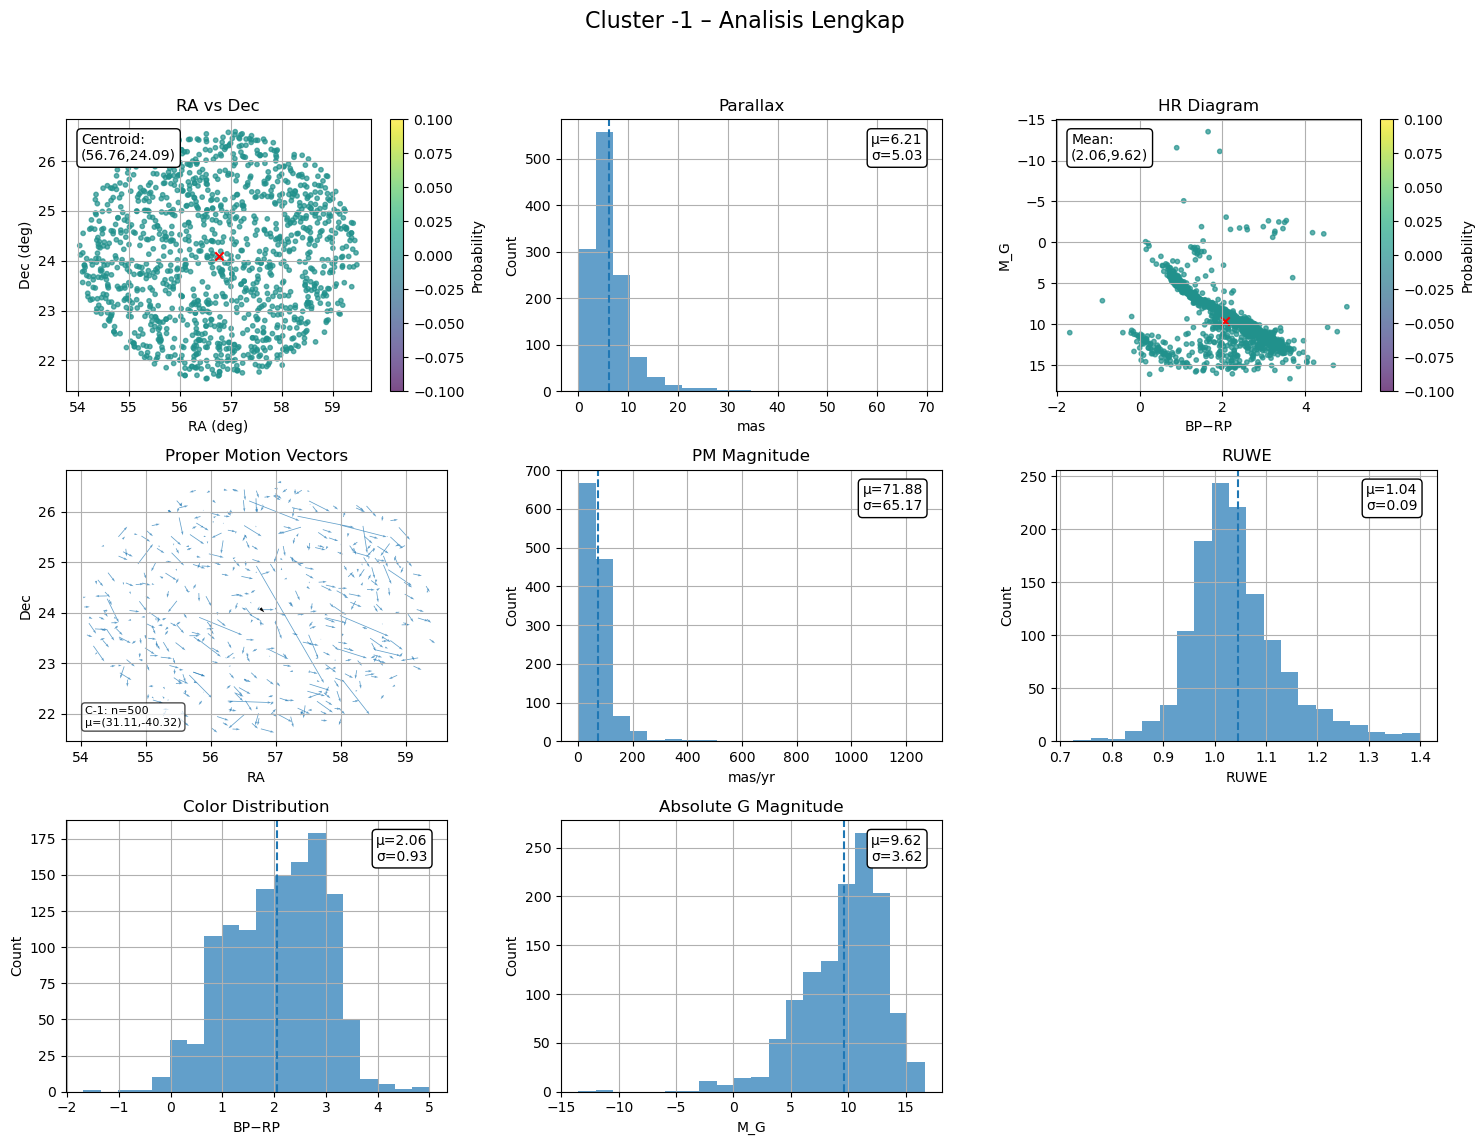


===== Cluster 0: 1151 bintang =====
        parallax       pmra      pmdec     color        M_G
mean    7.290934  19.686054 -44.924833  2.551569   9.908585
std     0.499311   2.244598   3.085357  0.926061   2.956889
median  7.349364  19.806101 -45.338442  2.924084  10.784653


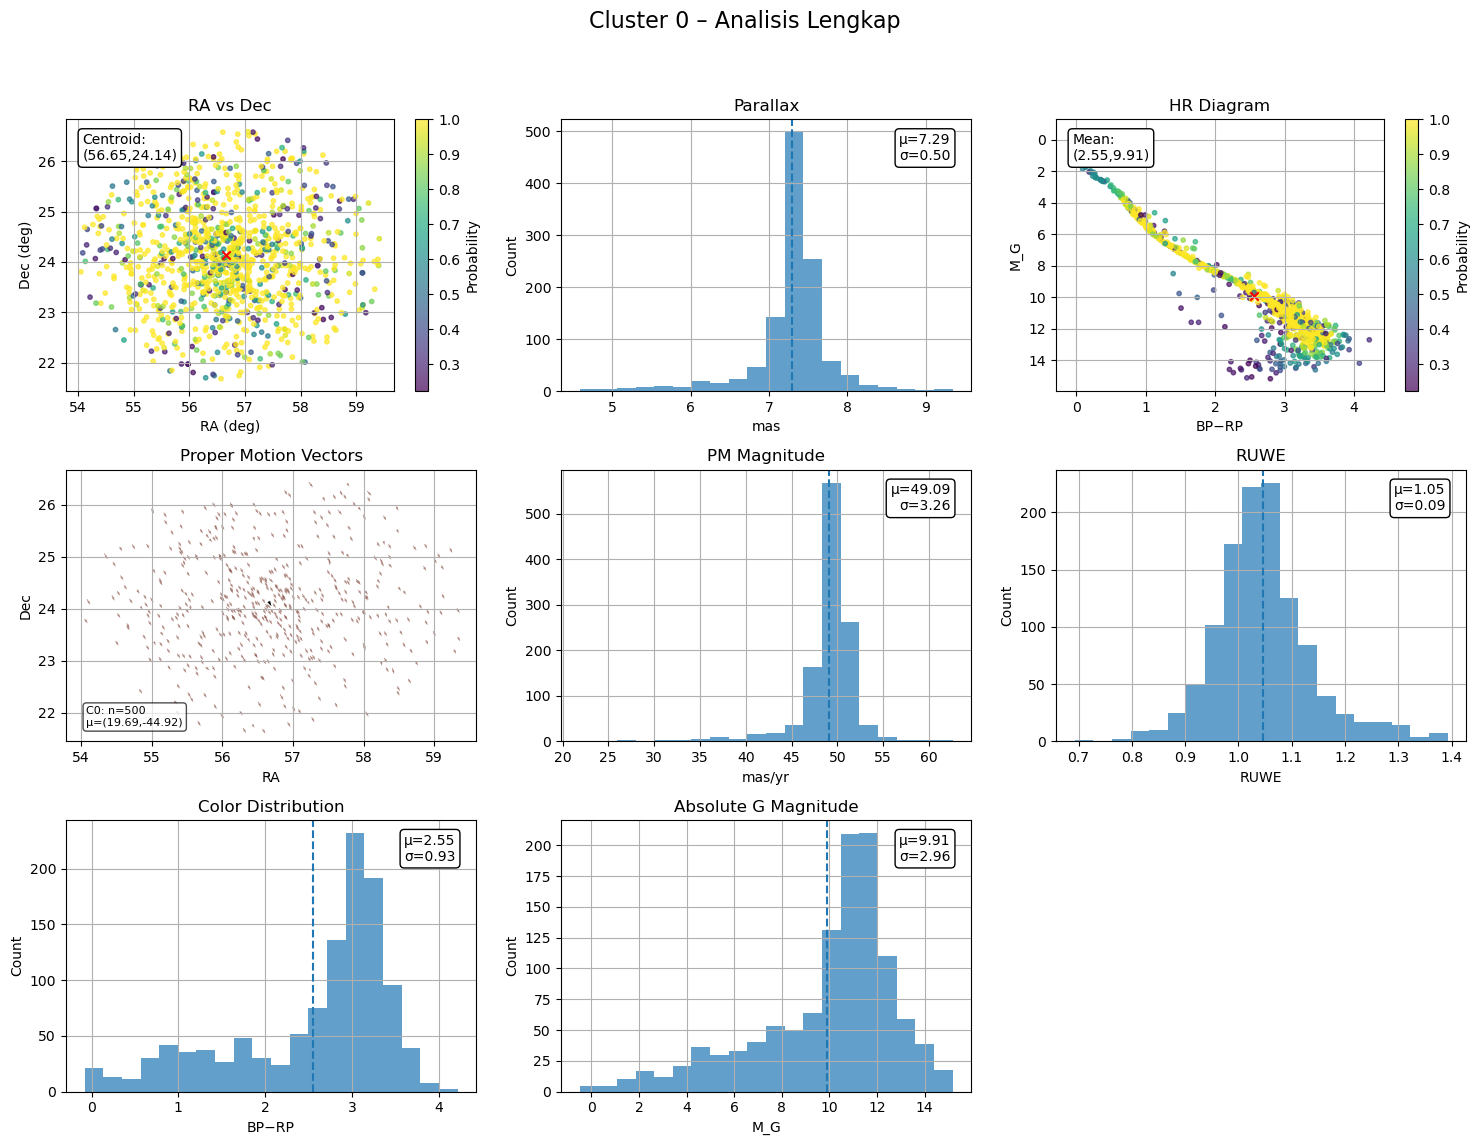


===== Cluster 1: 122035 bintang =====
        parallax      pmra     pmdec     color       M_G
mean    0.905670  2.666412 -4.280871  1.540796  7.211825
std     0.837525  6.211842  6.247992  0.551680  2.927729
median  0.655263  1.396745 -2.620542  1.402704  7.200315


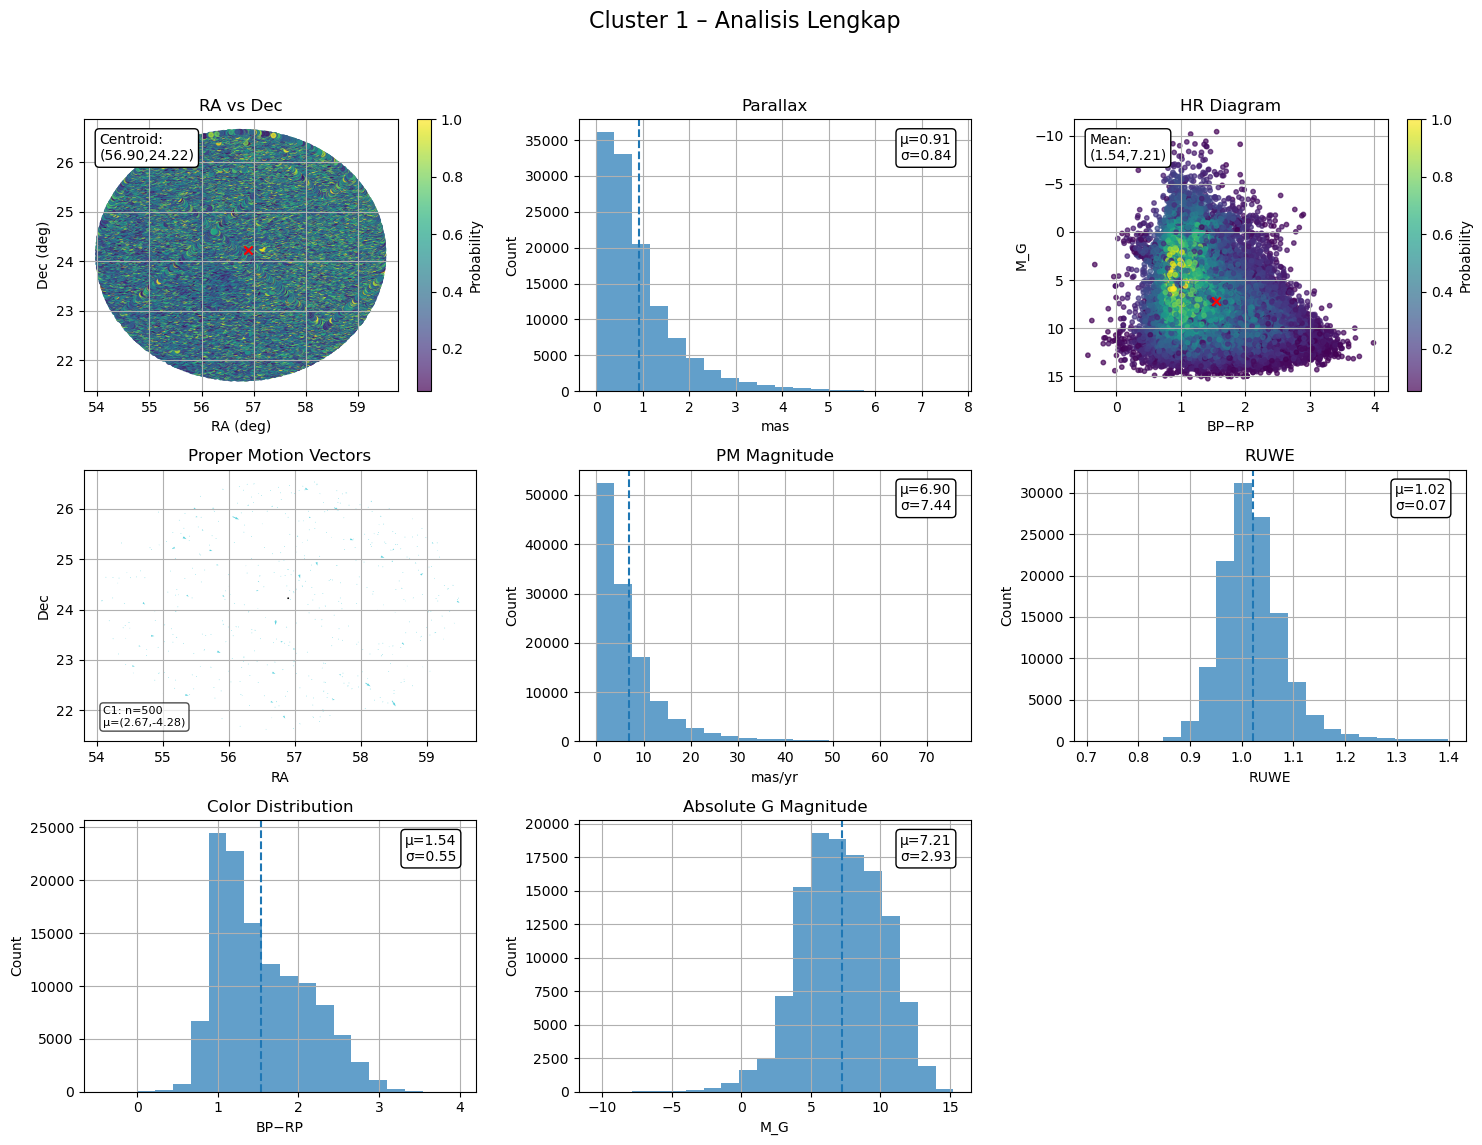

In [ ]:
# mapping warna per cluster (sisipkan ini sebelum loop)
cmap = cm.get_cmap('tab10', len(unique_labels))
cluster_colors = {lbl: cmap(i) for i, lbl in enumerate(unique_labels)}

MAX_ARROWS = 500

for lbl in unique_labels:
    subset = data[data['cluster']==lbl]
    count  = len(subset)
    print(f"\n===== Cluster {lbl}: {count} bintang =====")
    # deskriptif singkat tiap fitur
    desc = subset[features].describe().loc[['mean','std','50%']].rename(index={'50%':'median'})
    print(desc)

    fig, axes = plt.subplots(3,3,figsize=(15,12))
    fig.suptitle(f'Cluster {lbl} – Analisis Lengkap', fontsize=16)

    # (0,0) RA vs Dec + centroid
    ax = axes[0,0]
    sc = ax.scatter(subset['ra'], subset['dec'], s=10, alpha=0.7,
                    c=subset['probability'], cmap='viridis')
    ax.set_title('RA vs Dec')
    ax.set_xlabel('RA (deg)'); ax.set_ylabel('Dec (deg)'); ax.grid(True)
    plt.colorbar(sc, ax=ax, label='Probability')
    ra_c, dec_c = subset['ra'].mean(), subset['dec'].mean()
    ax.scatter(ra_c, dec_c, color='red', marker='x')
    ax.text(0.05,0.95,
            f"Centroid:\n({ra_c:.2f},{dec_c:.2f})",
            transform=ax.transAxes, ha='left', va='top',
            bbox=dict(boxstyle="round", fc="w"))

    # (0,1) Parallax + mean/std
    ax = axes[0,1]
    ax.hist(subset['parallax'], bins=20, alpha=0.7)
    ax.set_title('Parallax')
    ax.set_xlabel('mas'); ax.set_ylabel('Count'); ax.grid(True)
    p_m, p_s = subset['parallax'].mean(), subset['parallax'].std()
    ax.axvline(p_m, linestyle='--')
    ax.text(0.95,0.95, f"μ={p_m:.2f}\nσ={p_s:.2f}",
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle="round", fc="w"))

    # (0,2) HR Diagram + mean point
    ax = axes[0,2]
    sc = ax.scatter(subset['color'], subset['M_G'], s=10, alpha=0.7,
                    c=subset['probability'], cmap='viridis')
    ax.invert_yaxis()
    ax.set_title('HR Diagram')
    ax.set_xlabel('BP−RP'); ax.set_ylabel('M_G'); ax.grid(True)
    plt.colorbar(sc, ax=ax, label='Probability')
    c_m, M_m = subset['color'].mean(), subset['M_G'].mean()
    ax.scatter(c_m, M_m, color='red', marker='x')
    ax.text(0.05,0.95, f"Mean:\n({c_m:.2f},{M_m:.2f})",
            transform=ax.transAxes, ha='left', va='top',
            bbox=dict(boxstyle="round", fc="w"))

    # (1,0) Proper Motion Vectors + centroid vector 
    ax = axes[1,0]
    arrows = subset.sample(min(len(subset), MAX_ARROWS), random_state=0)
    ax.quiver(
        arrows['ra'], arrows['dec'],
        arrows['pmra'], arrows['pmdec'],
        angles='xy', scale_units='xy', scale=500,
        width=0.002, alpha=0.7,
        color=cluster_colors[lbl]
    )
    # centroid arrow (black)
    pmra_m, pmdec_m = subset['pmra'].mean(), subset['pmdec'].mean()
    ax.quiver(
        ra_c, dec_c,
        pmra_m, pmdec_m,
        angles='xy', scale_units='xy', scale=500,
        width=0.005, color='black'
    )
    ax.set_title('Proper Motion Vectors')
    ax.set_xlabel('RA'); ax.set_ylabel('Dec'); ax.grid(True)
    ax.text(0.05,0.05,
            f"C{lbl}: n={len(arrows)}\nμ=({pmra_m:.2f},{pmdec_m:.2f})",
            transform=ax.transAxes, ha='left', va='bottom',
            fontsize=8, bbox=dict(boxstyle="round,pad=0.3", fc="w", alpha=0.7))

    # (1,1) PM Magnitude + mean/std
    ax = axes[1,1]
    pm_vals = np.sqrt(subset['pmra']**2 + subset['pmdec']**2)
    ax.hist(pm_vals, bins=20, alpha=0.7)
    ax.set_title('PM Magnitude')
    ax.set_xlabel('mas/yr'); ax.set_ylabel('Count'); ax.grid(True)
    m_pm, s_pm = pm_vals.mean(), pm_vals.std()
    ax.axvline(m_pm, linestyle='--')
    ax.text(0.95,0.95, f"μ={m_pm:.2f}\nσ={s_pm:.2f}",
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle="round", fc="w"))

    # (1,2) RUWE + mean/std
    ax = axes[1,2]
    ax.hist(subset['ruwe'], bins=20, alpha=0.7)
    ax.set_title('RUWE')
    ax.set_xlabel('RUWE'); ax.set_ylabel('Count'); ax.grid(True)
    m_ru, s_ru = subset['ruwe'].mean(), subset['ruwe'].std()
    ax.axvline(m_ru, linestyle='--')
    ax.text(0.95,0.95, f"μ={m_ru:.2f}\nσ={s_ru:.2f}",
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle="round", fc="w"))

    # (2,0) Color Distribution + mean/std
    ax = axes[2,0]
    ax.hist(subset['color'], bins=20, alpha=0.7)
    ax.set_title('Color Distribution')
    ax.set_xlabel('BP−RP'); ax.set_ylabel('Count'); ax.grid(True)
    m_col, s_col = subset['color'].mean(), subset['color'].std()
    ax.axvline(m_col, linestyle='--')
    ax.text(0.95,0.95, f"μ={m_col:.2f}\nσ={s_col:.2f}",
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle="round", fc="w"))

    # (2,1) Absolute G Magnitude + mean/std
    ax = axes[2,1]
    ax.hist(subset['M_G'], bins=20, alpha=0.7)
    ax.set_title('Absolute G Magnitude')
    ax.set_xlabel('M_G'); ax.set_ylabel('Count'); ax.grid(True)
    mMG, sMG = subset['M_G'].mean(), subset['M_G'].std()
    ax.axvline(mMG, linestyle='--')
    ax.text(0.95,0.95, f"μ={mMG:.2f}\nσ={sMG:.2f}",
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle="round", fc="w"))

    # (2,2) blank
    axes[2,2].axis('off')

    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.show()


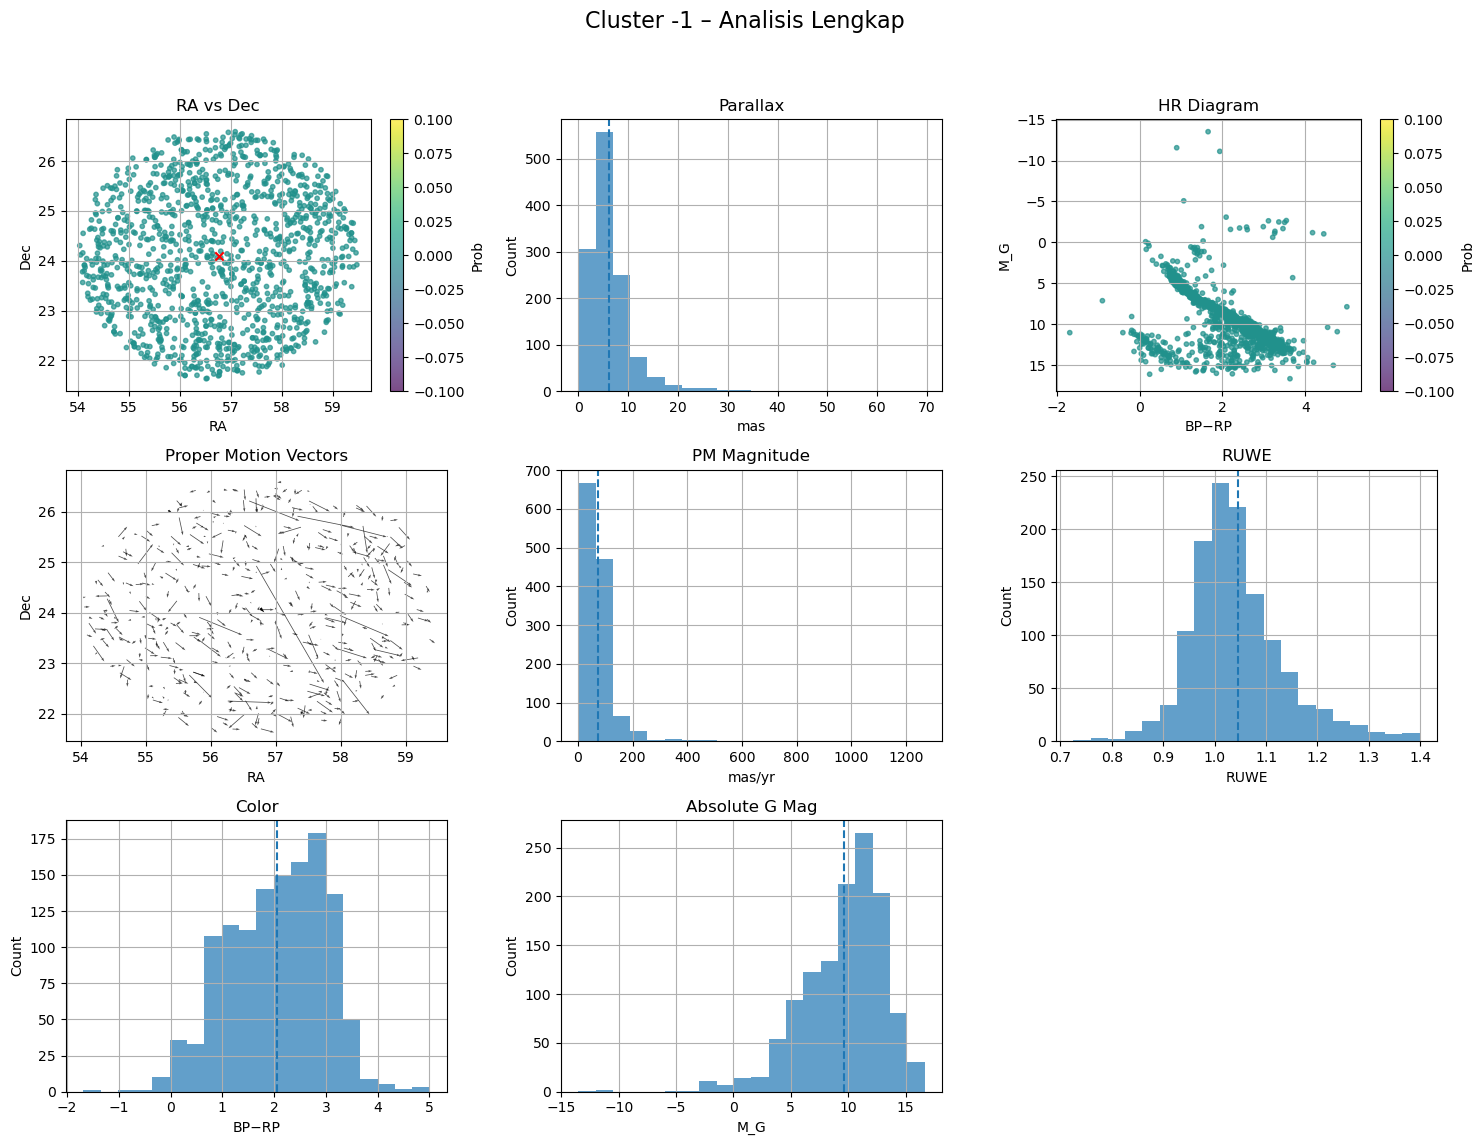

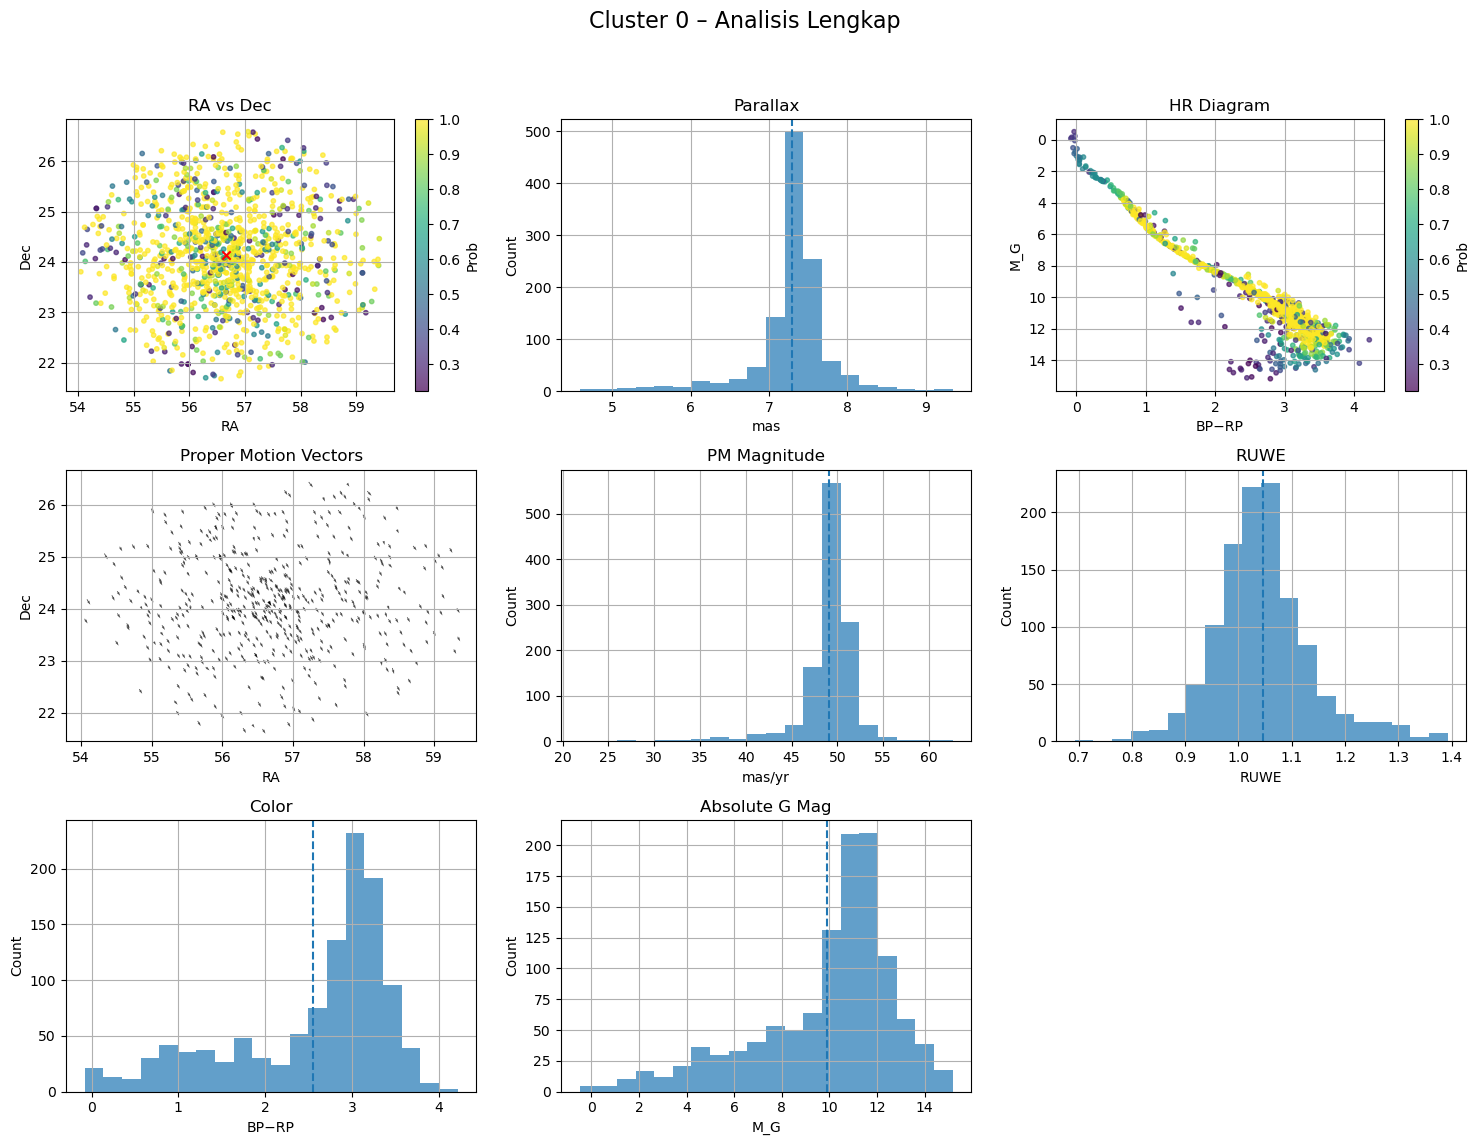

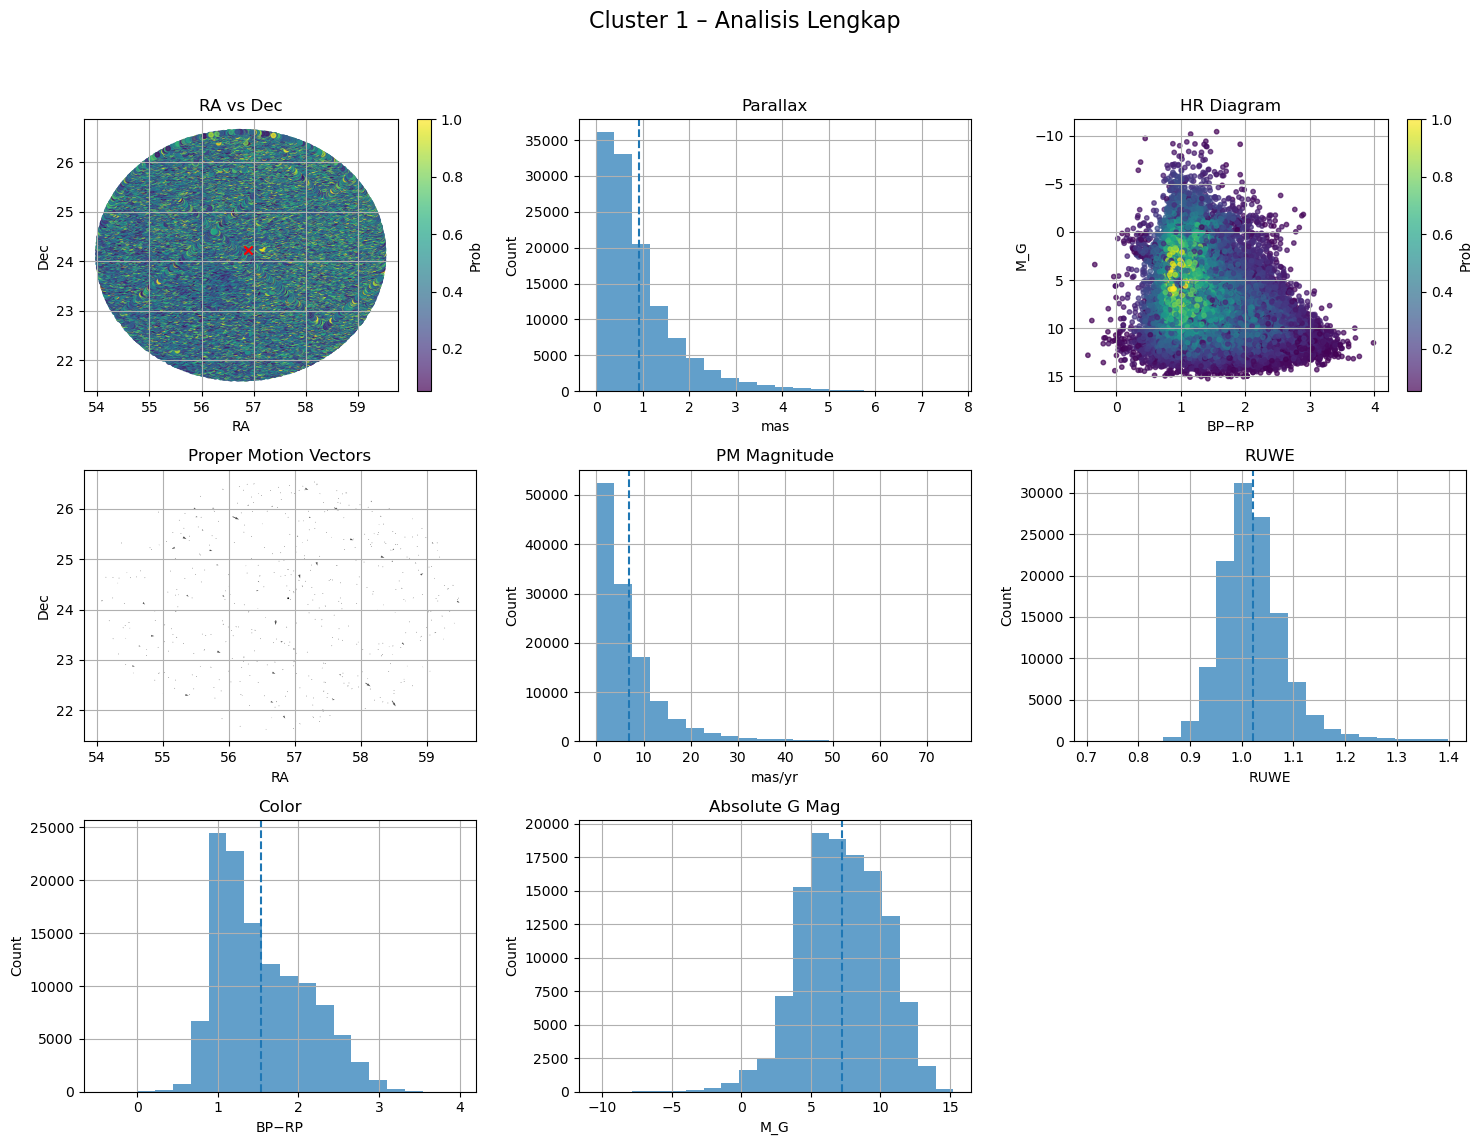

In [148]:
MAX_ARROWS = 500
for lbl in unique_labels:
    subset = data[data['cluster']==lbl]
    ra_c, dec_c     = subset['ra'].mean(), subset['dec'].mean()
    pmra_c, pmdec_c = subset['pmra'].mean(), subset['pmdec'].mean()
    fig, axes = plt.subplots(3,3,figsize=(15,12))
    fig.suptitle(f'Cluster {lbl} – Analisis Lengkap', fontsize=16)

    # (0,0) RA vs Dec
    ax = axes[0,0]
    sc = ax.scatter(subset['ra'], subset['dec'], s=10, alpha=0.7, c=subset['probability'], cmap='viridis')
    ax.scatter(ra_c, dec_c, color='red', marker='x')
    ax.set(title='RA vs Dec', xlabel='RA', ylabel='Dec'); ax.grid(True)
    plt.colorbar(sc, ax=ax, label='Prob')

    # (0,1) Parallax
    ax = axes[0,1]
    ax.hist(subset['parallax'], bins=20, alpha=0.7)
    ax.axvline(subset['parallax'].mean(), linestyle='--')
    ax.set(title='Parallax', xlabel='mas', ylabel='Count'); ax.grid(True)

    # (0,2) HR Diagram
    ax = axes[0,2]
    sc = ax.scatter(subset['color'], subset['M_G'], s=10, alpha=0.7, c=subset['probability'], cmap='viridis')
    ax.invert_yaxis()
    ax.set(title='HR Diagram', xlabel='BP−RP', ylabel='M_G'); ax.grid(True)
    plt.colorbar(sc, ax=ax, label='Prob')

    # (1,0) Proper motion vectors
    ax = axes[1,0]
    arrows = subset.sample(min(len(subset), MAX_ARROWS), random_state=0)
    ax.quiver(arrows['ra'], arrows['dec'], arrows['pmra'], arrows['pmdec'],
              angles='xy', scale_units='xy', scale=500, width=0.002, alpha=0.7)
    ax.quiver(ra_c, dec_c, pmra_c, pmdec_c, angles='xy',
              scale_units='xy', scale=500, width=0.005, color='black')
    ax.set(title='Proper Motion Vectors', xlabel='RA', ylabel='Dec'); ax.grid(True)

    # (1,1) PM magnitude
    ax = axes[1,1]
    pm_vals = np.sqrt(subset['pmra']**2 + subset['pmdec']**2)
    ax.hist(pm_vals, bins=20, alpha=0.7)
    ax.axvline(pm_vals.mean(), linestyle='--')
    ax.set(title='PM Magnitude', xlabel='mas/yr', ylabel='Count'); ax.grid(True)

    # (1,2) RUWE
    ax = axes[1,2]
    ax.hist(subset['ruwe'], bins=20, alpha=0.7)
    ax.axvline(subset['ruwe'].mean(), linestyle='--')
    ax.set(title='RUWE', xlabel='RUWE', ylabel='Count'); ax.grid(True)

    # (2,0) Color
    ax = axes[2,0]
    ax.hist(subset['color'], bins=20, alpha=0.7)
    ax.axvline(subset['color'].mean(), linestyle='--')
    ax.set(title='Color', xlabel='BP−RP', ylabel='Count'); ax.grid(True)

    # (2,1) Absolute G Mag
    ax = axes[2,1]
    ax.hist(subset['M_G'], bins=20, alpha=0.7)
    ax.axvline(subset['M_G'].mean(), linestyle='--')
    ax.set(title='Absolute G Mag', xlabel='M_G', ylabel='Count'); ax.grid(True)

    # (2,2) blank
    axes[2,2].axis('off')

    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.show()

In [149]:
# Rangkuman Numerik per cluster
data['pm_magnitude'] = np.sqrt(data['pmra']**2 + data['pmdec']**2)
summary = data.groupby('cluster').agg(
    count            = ('cluster','count'),
    ra_centroid      = ('ra','mean'),
    dec_centroid     = ('dec','mean'),
    pmra_centroid    = ('pmra','mean'),
    pmdec_centroid   = ('pmdec','mean'),
    parallax_mean    = ('parallax','mean'),
    parallax_std     = ('parallax','std'),
    pm_mag_mean      = ('pm_magnitude','mean'),
    pm_mag_std       = ('pm_magnitude','std'),
    color_mean       = ('color','mean'),
    color_std        = ('color','std'),
    M_G_mean         = ('M_G','mean'),
    M_G_std          = ('M_G','std')
).reset_index()
print("\nRangkuman Numerik per Cluster:")
print(summary.to_string(index=False))


Rangkuman Numerik per Cluster:
 cluster  count  ra_centroid  dec_centroid  pmra_centroid  pmdec_centroid  parallax_mean  parallax_std  pm_mag_mean  pm_mag_std  color_mean  color_std  M_G_mean  M_G_std
      -1   1250    56.757202     24.090912      31.107833      -40.317112       6.210686      5.026705    71.876486   65.166038    2.061844   0.928987  9.621173 3.622030
       0   1151    56.653859     24.141298      19.686054      -44.924833       7.290934      0.499311    49.088732    3.260666    2.551569   0.926061  9.908585 2.956889
       1 122035    56.896916     24.224748       2.666412       -4.280871       0.905670      0.837525     6.904779    7.442032    1.540796   0.551680  7.211825 2.927729


# Analisis Data Valid Pleiades

In [150]:
df = pd.read_csv('pleiadesvalid.csv')
print(f"Total baris data valid: {len(df)}")

Total baris data valid: 1272


In [151]:
data = df.rename(columns={
    'RA_ICRS': 'ra',
    'DE_ICRS': 'dec',
    'plx': 'parallax',
    'Bp-Rp': 'color',
    'Gmag': 'Gmag',
    'pmRA': 'pmra',
    'pmDE': 'pmdec'
})
data['M_G'] = data['Gmag'] + 5 * np.log10(data['parallax'] / 1000) + 5

In [152]:
features = ['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'color', 'M_G']
stats = data[features].describe().loc[['count', 'mean', 'std', '50%', 'min', 'max']]
stats = stats.rename(index={'50%': 'median'})
print("\nStatistik deskriptif dataset valid:")
print(stats)


Statistik deskriptif dataset valid:
                 ra          dec     parallax         pmra        pmdec  \
count   1272.000000  1272.000000  1272.000000  1272.000000  1272.000000   
mean      56.623781    24.118551     7.372044    19.914866   -45.402335   
std        1.291426     1.222480     0.189770     1.128968     1.345939   
median    56.613950    24.106350     7.370000    19.920000   -45.400000   
min       52.596500    20.149800     6.880000    15.790000   -50.030000   
max       61.190300    27.982000     7.940000    24.020000   -40.790000   

              color          M_G  
count   1249.000000  1271.000000  
mean       2.466205     9.541917  
std        0.962382     2.995462  
median     2.875100    10.487838  
min       -0.403500    -1.712723  
max        4.075400    14.850809  


In [ ]:
ra_c   = data['ra'].mean()
dec_c  = data['dec'].mean()
pmra_c = data['pmra'].mean()
pmdec_c= data['pmdec'].mean()
c_c    = data['color'].mean()
M_c    = data['M_G'].mean()
pm     = data['parallax'].mean()
ps     = data['parallax'].std()
pm_mag = np.sqrt(data['pmra']**2 + data['pmdec']**2)
m_pm   = pm_mag.mean()
s_pm   = pm_mag.std()

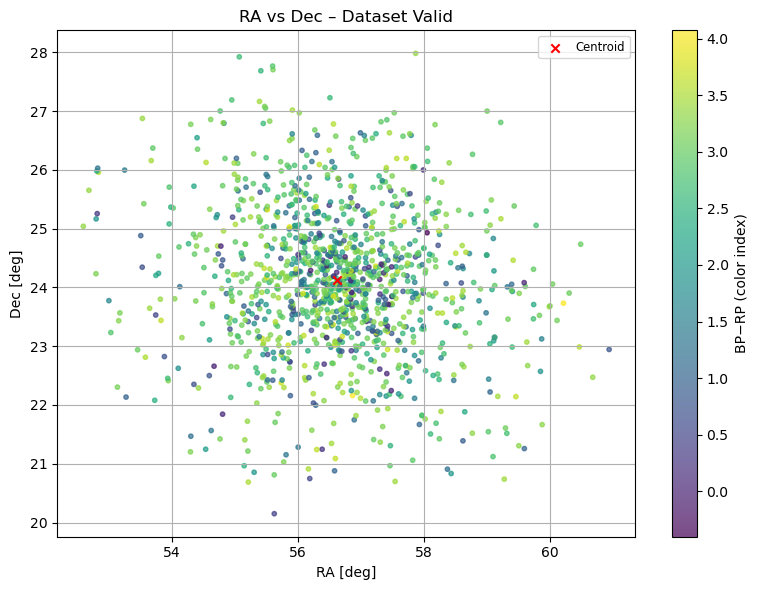

In [ ]:
plt.figure(figsize=(8,6))
sc = plt.scatter(data['ra'], data['dec'], c=data['color'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(sc, label='BP−RP (color index)')
plt.scatter(ra_c, dec_c, color='red', marker='x', label='Centroid')
plt.title('RA vs Dec – Dataset Valid'); plt.xlabel('RA [deg]'); plt.ylabel('Dec [deg]')
plt.legend(fontsize='small'); plt.grid(True); plt.tight_layout(); plt.show()

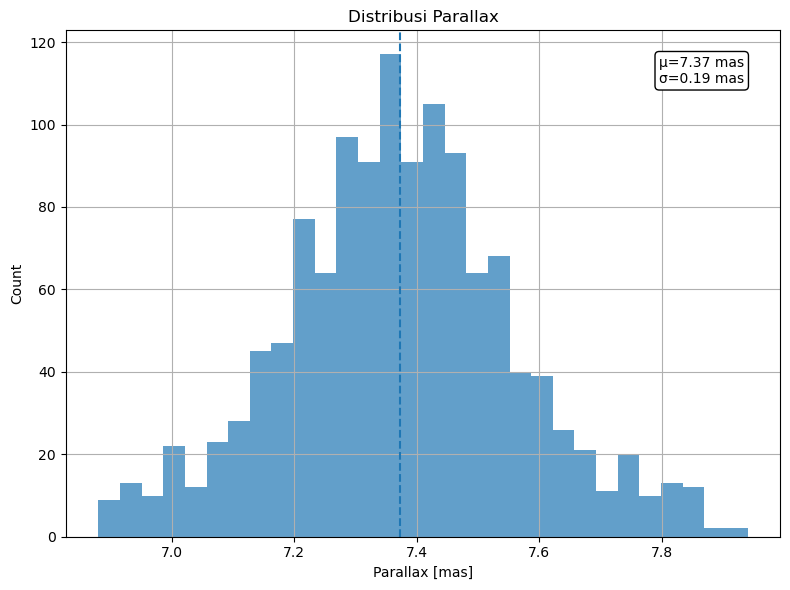

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(data['parallax'], bins=30, alpha=0.7)
plt.axvline(pm, linestyle='--')
plt.text(0.95, 0.95, f"μ={pm:.2f} mas\nσ={ps:.2f} mas", transform=plt.gca().transAxes,
         ha='right', va='top', bbox=dict(boxstyle='round', fc='w'))
plt.title('Distribusi Parallax'); plt.xlabel('Parallax [mas]'); plt.ylabel('Count'); plt.grid(True); plt.tight_layout(); plt.show()

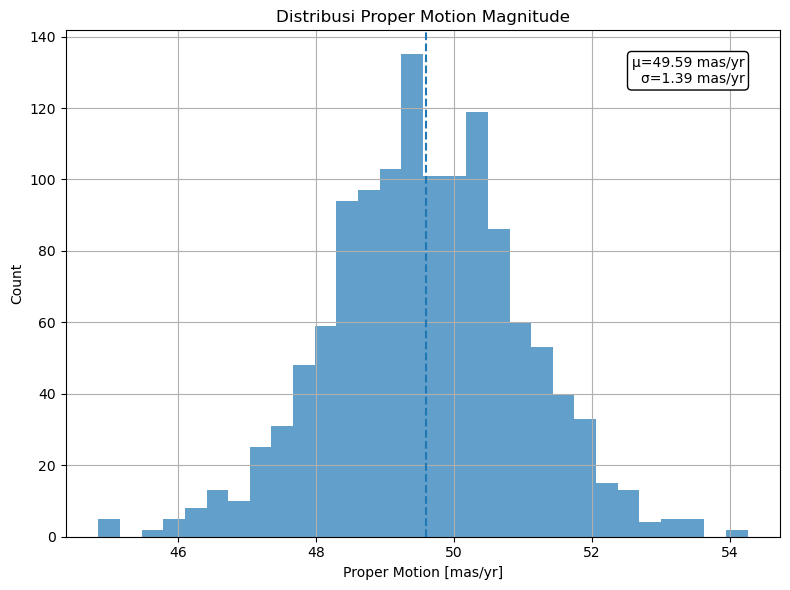

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(pm_mag, bins=30, alpha=0.7)
plt.axvline(m_pm, linestyle='--')
plt.text(0.95, 0.95, f"μ={m_pm:.2f} mas/yr\nσ={s_pm:.2f} mas/yr",
         transform=plt.gca().transAxes, ha='right', va='top', bbox=dict(boxstyle='round', fc='w'))
plt.title('Distribusi Proper Motion Magnitude'); plt.xlabel('Proper Motion [mas/yr]'); plt.ylabel('Count'); plt.grid(True); plt.tight_layout(); plt.show()


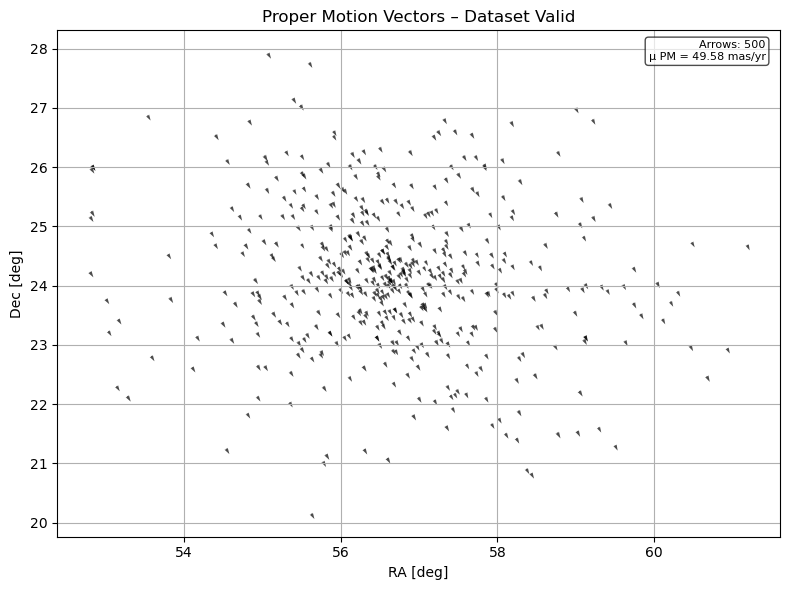

In [ ]:
plt.figure(figsize=(8,6))
MAX_ARROWS = 500
arrows = data.sample(min(len(data), MAX_ARROWS), random_state=0)
plt.quiver(arrows['ra'], arrows['dec'], arrows['pmra'], arrows['pmdec'],
           angles='xy', scale_units='xy', scale=500, width=0.002, alpha=0.7)
plt.quiver(ra_c, dec_c, data['pmra'].mean(), data['pmdec'].mean(),
           angles='xy', scale_units='xy', scale=500, width=0.005, color='black')
summary = (f"Arrows: {len(arrows)}\n"
           f"μ PM = {np.sqrt(data['pmra'].mean()**2 + data['pmdec'].mean()**2):.2f} mas/yr")
plt.text(0.98, 0.98, summary,
         transform=plt.gca().transAxes, ha='right', va='top',
         fontsize=8, bbox=dict(boxstyle='round,pad=0.3', fc='w', alpha=0.7))
plt.title('Proper Motion Vectors – Dataset Valid')
plt.xlabel('RA [deg]'); plt.ylabel('Dec [deg]'); plt.grid(True)
plt.tight_layout(); plt.show()


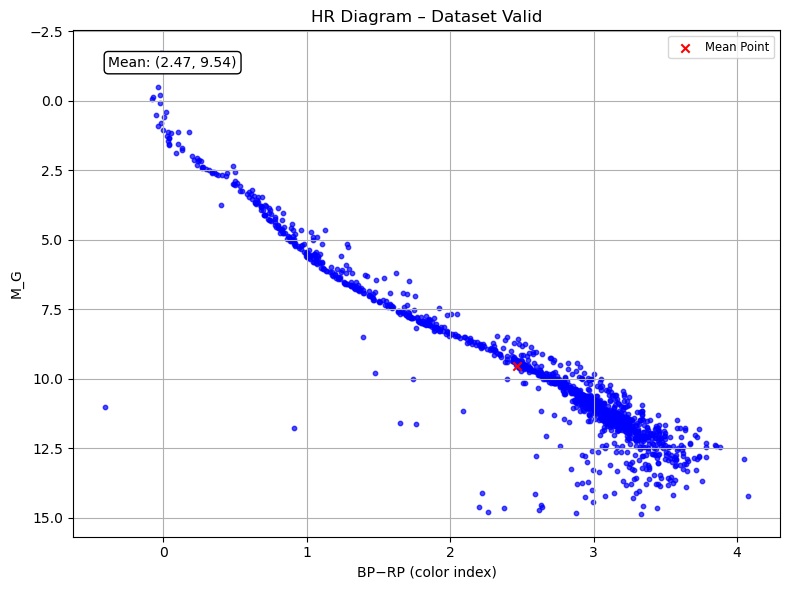

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(data['color'], data['M_G'], s=10, alpha=0.7, c='blue')
plt.gca().invert_yaxis()
plt.scatter(c_c, M_c, color='red', marker='x', label='Mean Point')
plt.text(0.05, 0.95, f"Mean: ({c_c:.2f}, {M_c:.2f})", transform=plt.gca().transAxes,
         ha='left', va='top', bbox=dict(boxstyle='round', fc='w'))
plt.title('HR Diagram – Dataset Valid'); plt.xlabel('BP−RP (color index)'); plt.ylabel('M_G'); plt.legend(fontsize='small'); plt.grid(True); plt.tight_layout(); plt.show()


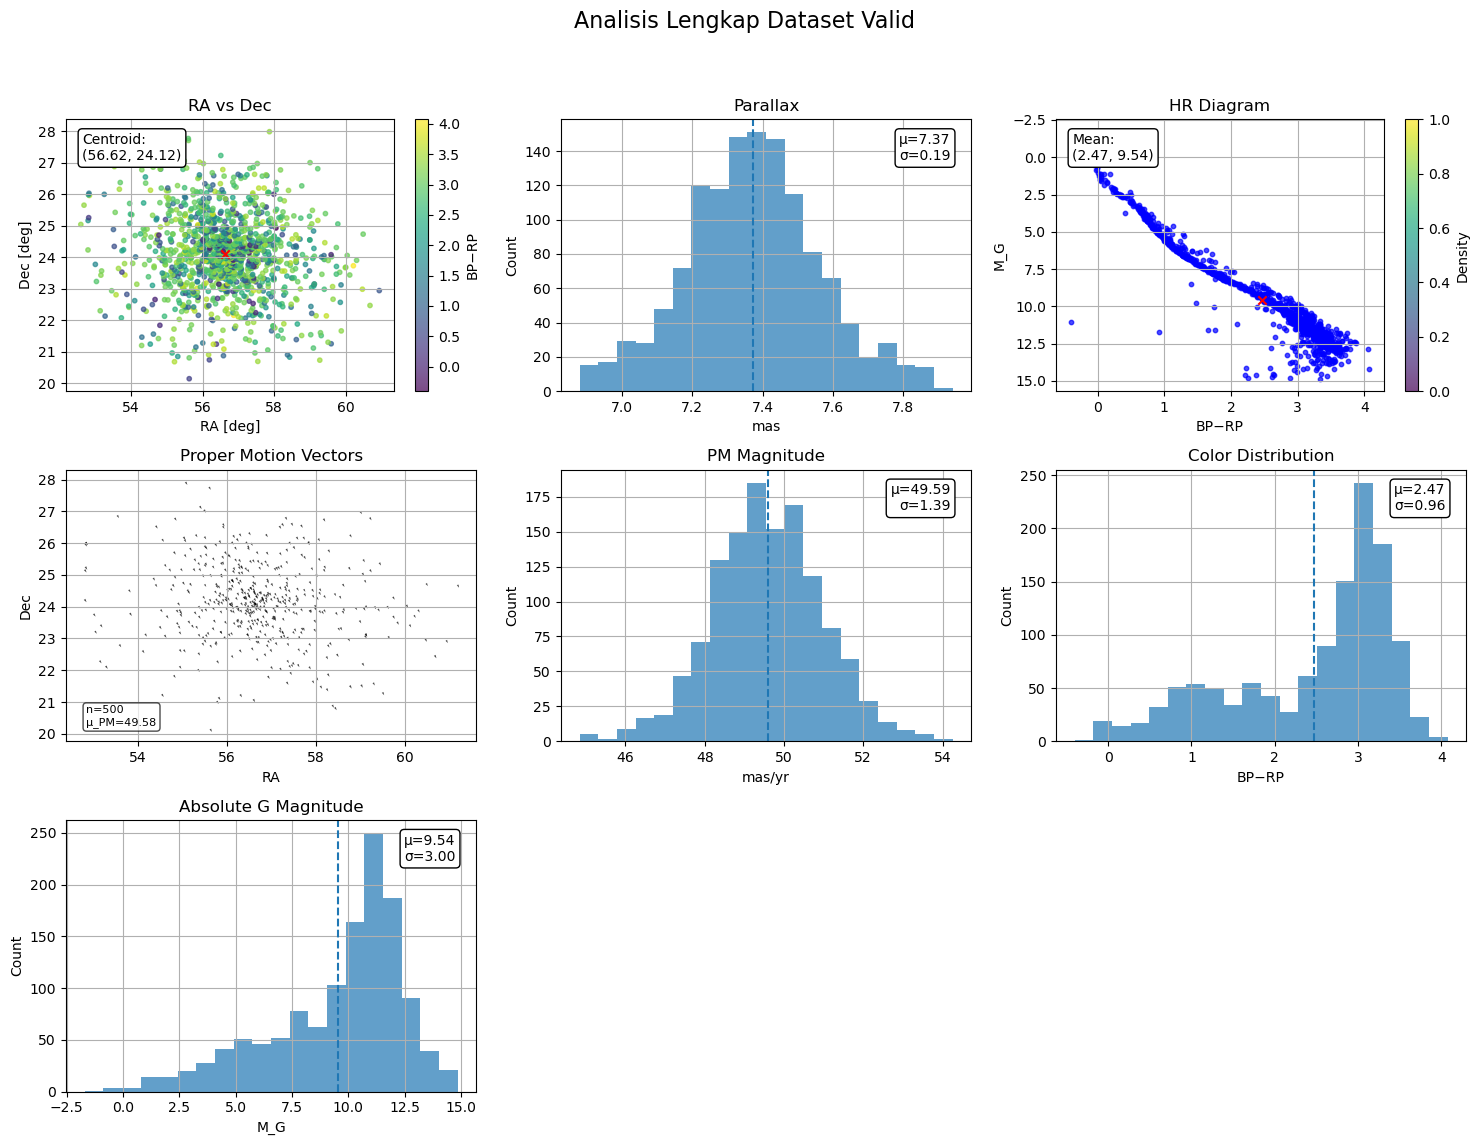

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Analisis Lengkap Dataset Valid', fontsize=16)

# (0,0) RA vs Dec
ax = axes[0, 0]
sc = ax.scatter(data['ra'], data['dec'], s=10, alpha=0.7, c=data['color'], cmap='viridis')
ax.set_title('RA vs Dec'); ax.set_xlabel('RA [deg]'); ax.set_ylabel('Dec [deg]'); ax.grid(True)
plt.colorbar(sc, ax=ax, label='BP−RP')
ax.scatter(ra_c, dec_c, color='red', marker='x')
ax.text(0.05, 0.95, f"Centroid:\n({ra_c:.2f}, {dec_c:.2f})",
        transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle='round', fc='w'))

# (0,1) Parallax
ax = axes[0, 1]
ax.hist(data['parallax'], bins=20, alpha=0.7)
ax.set_title('Parallax'); ax.set_xlabel('mas'); ax.set_ylabel('Count'); ax.grid(True)
ax.axvline(pm, linestyle='--')
ax.text(0.95, 0.95, f"μ={pm:.2f}\nσ={ps:.2f}",
        transform=ax.transAxes, ha='right', va='top', bbox=dict(boxstyle='round', fc='w'))

# (0,2) HR Diagram
ax = axes[0, 2]
sc = ax.scatter(data['color'], data['M_G'], s=10, alpha=0.7, c='blue')
ax.invert_yaxis()
ax.set_title('HR Diagram'); ax.set_xlabel('BP−RP'); ax.set_ylabel('M_G'); ax.grid(True)
plt.colorbar(sc, ax=ax, label='Density')
ax.scatter(c_c, M_c, color='red', marker='x')
ax.text(0.05, 0.95, f"Mean:\n({c_c:.2f}, {M_c:.2f})",
        transform=ax.transAxes, ha='left', va='top', bbox=dict(boxstyle='round', fc='w'))

# (1,0) Proper Motion Vectors
ax = axes[1, 0]
sample = data.sample(min(len(data), MAX_ARROWS), random_state=0)
ax.quiver(sample['ra'], sample['dec'], sample['pmra'], sample['pmdec'],
          angles='xy', scale_units='xy', scale=500, width=0.002, alpha=0.7)
ax.quiver(ra_c, dec_c, data['pmra'].mean(), data['pmdec'].mean(),
          angles='xy', scale_units='xy', scale=500, width=0.005, color='black')
ax.set_title('Proper Motion Vectors'); ax.set_xlabel('RA'); ax.set_ylabel('Dec'); ax.grid(True)
ax.text(0.05, 0.05, f"n={len(sample)}\nμ_PM={np.sqrt(data['pmra'].mean()**2 + data['pmdec'].mean()**2):.2f}",
        transform=ax.transAxes, ha='left', va='bottom', fontsize=8, bbox=dict(boxstyle='round', fc='w', alpha=0.7))

# (1,1) PM Magnitude
ax = axes[1, 1]
ax.hist(pm_mag, bins=20, alpha=0.7)
ax.set_title('PM Magnitude'); ax.set_xlabel('mas/yr'); ax.set_ylabel('Count'); ax.grid(True)
ax.axvline(m_pm, linestyle='--')
ax.text(0.95, 0.95, f"μ={m_pm:.2f}\nσ={s_pm:.2f}",
        transform=ax.transAxes, ha='right', va='top', bbox=dict(boxstyle='round', fc='w'))

# (1,2) Color Distribution
ax = axes[1, 2]
ax.hist(data['color'], bins=20, alpha=0.7)
ax.set_title('Color Distribution'); ax.set_xlabel('BP−RP'); ax.set_ylabel('Count'); ax.grid(True)
ax.axvline(data['color'].mean(), linestyle='--')
ax.text(0.95, 0.95, f"μ={data['color'].mean():.2f}\nσ={data['color'].std():.2f}",
        transform=ax.transAxes, ha='right', va='top', bbox=dict(boxstyle='round', fc='w'))

# (2,0) Absolute G Magnitude
ax = axes[2, 0]
ax.hist(data['M_G'], bins=20, alpha=0.7)
ax.set_title('Absolute G Magnitude'); ax.set_xlabel('M_G'); ax.set_ylabel('Count'); ax.grid(True)
ax.axvline(data['M_G'].mean(), linestyle='--')
ax.text(0.95, 0.95, f"μ={data['M_G'].mean():.2f}\nσ={data['M_G'].std():.2f}",
        transform=ax.transAxes, ha='right', va='top', bbox=dict(boxstyle='round', fc='w'))

# (2,1) & (2,2) blank
axes[2, 1].axis('off')
axes[2, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [37]:
# 6. Rangkuman Numerik Akhir Valid
summary_valid = {
    'Total Stars':                len(data),
    'Centroid RA [deg]':          ra_c,
    'Centroid Dec [deg]':         dec_c,
    'Centroid pmRA [mas/yr]':     pmra_c,
    'Centroid pmDec [mas/yr]':    pmdec_c,
    'Centroid Color (BP−RP)':     c_c,
    'Centroid M_G':               M_c,
    'Mean Parallax [mas]':        pm,
    'Std Parallax [mas]':         ps,
    'Mean PM Magnitude [mas/yr]': m_pm,
    'Std PM Magnitude [mas/yr]':  s_pm
}
print("Rangkuman Numerik Akhir Valid:")
for k, v in summary_valid.items():
    print(f"{k:30s}: {v:.3f}")

Rangkuman Numerik Akhir Valid:
Total Stars                   : 1272.000
Centroid RA [deg]             : 56.624
Centroid Dec [deg]            : 24.119
Centroid pmRA [mas/yr]        : 19.915
Centroid pmDec [mas/yr]       : -45.402
Centroid Color (BP−RP)        : 2.466
Centroid M_G                  : 9.542
Mean Parallax [mas]           : 7.372
Std Parallax [mas]            : 0.190
Mean PM Magnitude [mas/yr]    : 49.590
Std PM Magnitude [mas/yr]     : 1.391
